In [1]:
import pandas as pd
import numpy as np

# 시각화 라이브러리 및 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib as mpl

font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

# 머신러닝 모델 및 도구
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
# 모든 경고문을 무시합니다.
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('카페_상권_데이터.csv')
df.head(2)

기준_년분기_코드 상권_구분_코드_명    상권_코드  상권_코드_명   분기_매출금액  총_상주인구_수  남성_상주인구_수  \
0      20221       골목상권  3110002  독립문역 1번  61342892       629        309   
1      20222       골목상권  3110002  독립문역 1번  89525560       629        309   

   여성_상주인구_수  연령대_10_상주인구_수  연령대_20_상주인구_수  ...  프랜차이즈_점포_수  평균 최저기온(℃)  \
0        320             79             57  ...           2       -2.72   
1        320             79             57  ...           2       14.58   

   평균 최고기온(℃)  총 강수량(mm)  평균 풍속(m/s)  평균 상대습도(%)  평균 현지기압(hPa)  일반음식점_점포수  \
0        6.48      112.8        2.43       57.37       1011.91         22   
1       24.36      421.7        2.60       61.18       1001.83         22   

   자치구  행정동  
0  종로구  무악동  
1  종로구  무악동  

[2 rows x 92 columns]

### 기준_년분기_코드 열 삭제  -> 년도와 분기로

In [3]:
# 기준년분기 분리 + 원래 열 제거
df['년도'] = df['기준_년분기_코드'].astype(str).str[:4].astype(int)
df['분기'] = df['기준_년분기_코드'].astype(str).str[4:].astype(int)
df.drop(columns=['기준_년분기_코드'], inplace=True)

front_columns = ['년도', '분기']
other_columns = [col for col in df.columns if col not in front_columns]
new_column_order = front_columns + other_columns
df = df[new_column_order]
df.drop(columns=['상권_구분_코드_명'], inplace=True)

### 3개년(12분기) 데이터가 모두 존재하는 상권만 필터링

In [4]:
code_2022 = set(df[df['년도'] == 2022]['상권_코드'].unique().tolist())
code_2023 = set(df[df['년도'] == 2023]['상권_코드'].unique().tolist())
code_2024 = set(df[df['년도'] == 2024]['상권_코드'].unique().tolist())
intersect_code = code_2022 & code_2023 & code_2024
df = df[df['상권_코드'].isin(intersect_code)]

record_counts = df.groupby('상권_코드').size()
not_12_records = record_counts[record_counts != 12]
not_12_records_list = not_12_records.index.tolist()
not_12_records_list
df = df[~df['상권_코드'].isin(not_12_records_list)]

In [5]:
df.rename(columns={'총_점포_수': '총_커피매장_수'}, inplace=True)

### 컬럼 순서 정리

In [6]:
order = [
    # 1. 기본 정보 (Identifiers & Location)
    '년도',
    '분기',
    '상권_코드',
    '상권_코드_명',
    '자치구',
    '행정동',

    # 2. 상권 및 점포 정보
    '총_커피매장_수',
    '일반_점포_수',
    '프랜차이즈_점포_수',
    '일반음식점_점포수',
    '상권_변화_지표_명',
    '운영_영업_개월_평균',
    '폐업_영업_개월_평균',
    '서울_운영_영업_개월_평균',
    '서울_폐업_영업_개월_평균',
    '집객시설_수',

    # 3. 상주인구 정보
    '총_상주인구_수',
    '남성_상주인구_수',
    '여성_상주인구_수',
    '연령대_10_상주인구_수',
    '연령대_20_상주인구_수',
    '연령대_30_상주인구_수',
    '연령대_40_상주인구_수',
    '연령대_50_상주인구_수',
    '연령대_60_이상_상주인구_수',
    '남성연령대_10_상주인구_수',
    '남성연령대_20_상주인구_수',
    '남성연령대_30_상주인구_수',
    '남성연령대_40_상주인구_수',
    '남성연령대_50_상주인구_수',
    '남성연령대_60_이상_상주인구_수',
    '여성연령대_10_상주인구_수',
    '여성연령대_20_상주인구_수',
    '여성연령대_30_상주인구_수',
    '여성연령대_40_상주인구_수',
    '여성연령대_50_상주인구_수',
    '여성연령대_60_이상_상주인구_수',

    # 4. 직장인구 정보
    '총_직장_인구_수',
    '남성_직장_인구_수',
    '여성_직장_인구_수',
    '연령대_10_직장_인구_수',
    '연령대_20_직장_인구_수',
    '연령대_30_직장_인구_수',
    '연령대_40_직장_인구_수',
    '연령대_50_직장_인구_수',
    '연령대_60_이상_직장_인구_수',
    '남성연령대_10_직장_인구_수',
    '남성연령대_20_직장_인구_수',
    '남성연령대_30_직장_인구_수',
    '남성연령대_40_직장_인구_수',
    '남성연령대_50_직장_인구_수',
    '남성연령대_60_이상_직장_인구_수',
    '여성연령대_10_직장_인구_수',
    '여성연령대_20_직장_인구_수',
    '여성연령대_30_직장_인구_수',
    '여성연령대_40_직장_인구_수',
    '여성연령대_50_직장_인구_수',
    '여성연령대_60_이상_직장_인구_수',

    # 5. 유동인구 정보
    '총_유동인구_수',
    '남성_유동인구_수',
    '여성_유동인구_수',
    '연령대_10_유동인구_수',
    '연령대_20_유동인구_수',
    '연령대_30_유동인구_수',
    '연령대_40_유동인구_수',
    '연령대_50_유동인구_수',
    '연령대_60_이상_유동인구_수',
    '시간대_00_06_유동인구_수',
    '시간대_06_11_유동인구_수',
    '시간대_11_14_유동인구_수',
    '시간대_14_17_유동인구_수',
    '시간대_17_21_유동인구_수',
    '시간대_21_24_유동인구_수',
    '월요일_유동인구_수',
    '화요일_유동인구_수',
    '수요일_유동인구_수',
    '목요일_유동인구_수',
    '금요일_유동인구_수',
    '토요일_유동인구_수',
    '일요일_유동인구_수',

    # 6. 소득 및 지출 정보
    '월_평균_소득_금액',
    '식료품_지출_총금액',
    '여가_지출_총금액',
    '문화_지출_총금액',
    '유흥_지출_총금액',
    
    # 7. 날씨 정보 (외부 요인)
    '평균 최저기온(℃)',
    '평균 최고기온(℃)',
    '총 강수량(mm)',
    '평균 풍속(m/s)',
    '평균 상대습도(%)',
    '평균 현지기압(hPa)',

    # 8. 타겟 변수 (Target Variable)
    '분기_매출금액'
]

df = df[order]

# EDA

### 연도별 및 분기별 매출 추이 분석

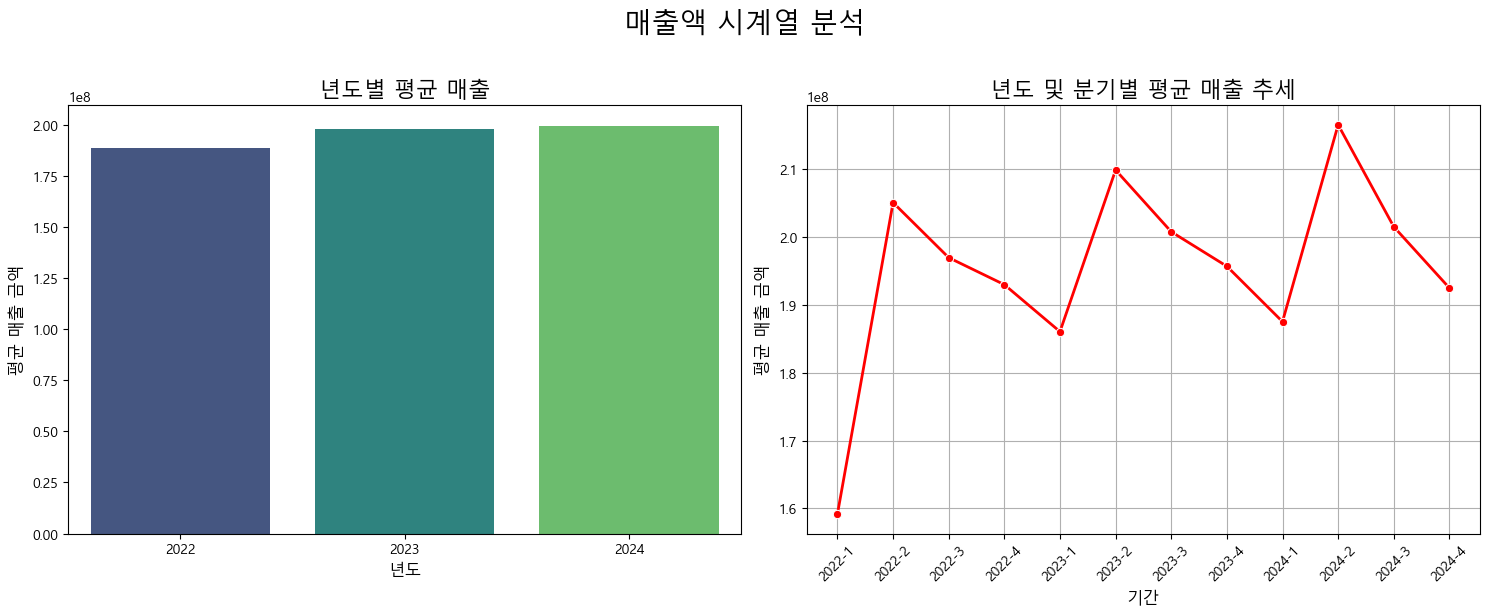

In [7]:
# 년도별 평균 매출
yearly_avg_sales = df.groupby('년도')['분기_매출금액'].mean().reset_index()

# 년도 및 분기별 평균 매출
quarterly_avg_sales = df.groupby(['년도', '분기'])['분기_매출금액'].mean().reset_index()
quarterly_avg_sales['period'] = quarterly_avg_sales['년도'].astype(str) + '-' + quarterly_avg_sales['분기'].astype(str)
quarterly_avg_sales = quarterly_avg_sales.sort_values(by=['년도', '분기'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. 년도별 평균 매출 (막대 그래프)
sns.barplot(x='년도', y='분기_매출금액', data=yearly_avg_sales, ax=axes[0], palette='viridis')
axes[0].set_title('년도별 평균 매출', fontsize=16)
axes[0].set_xlabel('년도', fontsize=12)
axes[0].set_ylabel('평균 매출 금액', fontsize=12)

# 2. 년도 및 분기별 평균 매출 (꺾은선 그래프)
sns.lineplot(x='period', y='분기_매출금액', data=quarterly_avg_sales, ax=axes[1], marker='o', color='red', linewidth=2)
axes[1].set_title('년도 및 분기별 평균 매출 추세', fontsize=16)
axes[1].set_xlabel('기간', fontsize=12)
axes[1].set_ylabel('평균 매출 금액', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].grid(True)

plt.suptitle('매출액 시계열 분석', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

- 분석 배경  
    데이터 분석 결과, 2022년 1분기 매출이 다른 분기에 비해 상대적으로 저조한 양상을 나타냈다. 이는 외부 환경적 요인이 상권 매출에 영향을 미쳤을 가능성을 시사한다.

* 가설 설정  
    2022년 4월에 시행된 사회적 거리두기 해제가 상권 매출 증가에 긍정적인 영향을 미쳤을 것이라는 가설을 설정한다.

* 분석 방안  
    2022년 2분기를 기준으로 '거리두기 시기'와 '해제 이후 시기'로 구분하는 파생변수를 생성한다. 이 두 그룹의 평균 매출을 비교 분석하여 해당 정책이 상권 매출에 미친 효과를 통계적으로 검증한다.

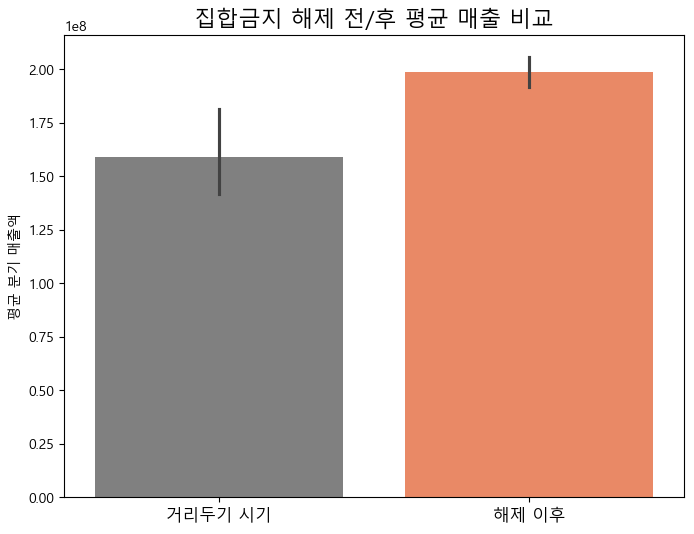

In [8]:
# '코로나_집합금지_영향' 파생변수 생성 (거리두기 시기 = 0, 해제 이후 = 1)
df['코로나_집합금지_영향'] = np.where((df['년도'] == 2022) & (df['분기'] < 2), 0, 1)

# 그룹별 평균 매출 계산 및 시각화
plt.figure(figsize=(8, 6))
sns.barplot(
    x='코로나_집합금지_영향',
    y='분기_매출금액',
    data=df,
    estimator=np.mean, # 평균값 계산
    palette=['gray', 'coral']
)

plt.title('집합금지 해제 전/후 평균 매출 비교', fontsize=16)
plt.ylabel('평균 분기 매출액')
plt.xlabel('')
plt.xticks(ticks=[0, 1], labels=['거리두기 시기', '해제 이후'], rotation=0, fontsize=12)
plt.show()

약 4천만원 정도의 유의미한 차이를 보임

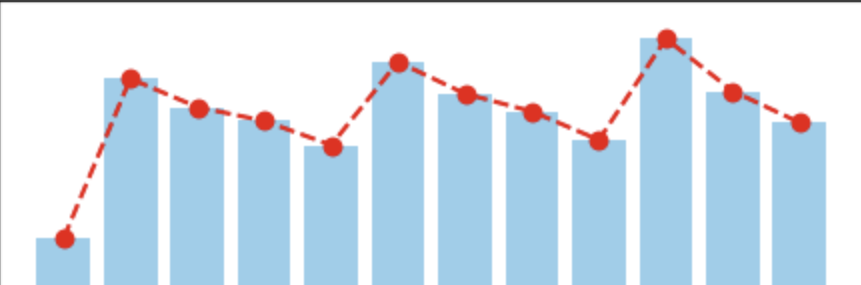

- 분석 배경  
    시계열 데이터 분석 결과, 연도와 관계없이 분기별로 유사한 매출 패턴이 반복되는 계절적 변동 현상이 관찰되었다. 이는 주요 기상 변수와 같은 외부 환경 요인이 매출에 영향을 미쳤을 가능성을 시사한다.

- 가설 설정  
    이러한 주기적인 매출 패턴은 '평균 최고기온', '총 강수량' 등 주요 기상 변수와 유의미한 통계적 연관성을 가질 것이라는 가설을 설정한다.

- 분석 방안  
    '분기_매출금액'과 주요 기상 변수 간의 상관관계 분석을 통해 두 변수 그룹 간의 정량적 관계를 규명하고, 가설의 타당성을 검증한다.

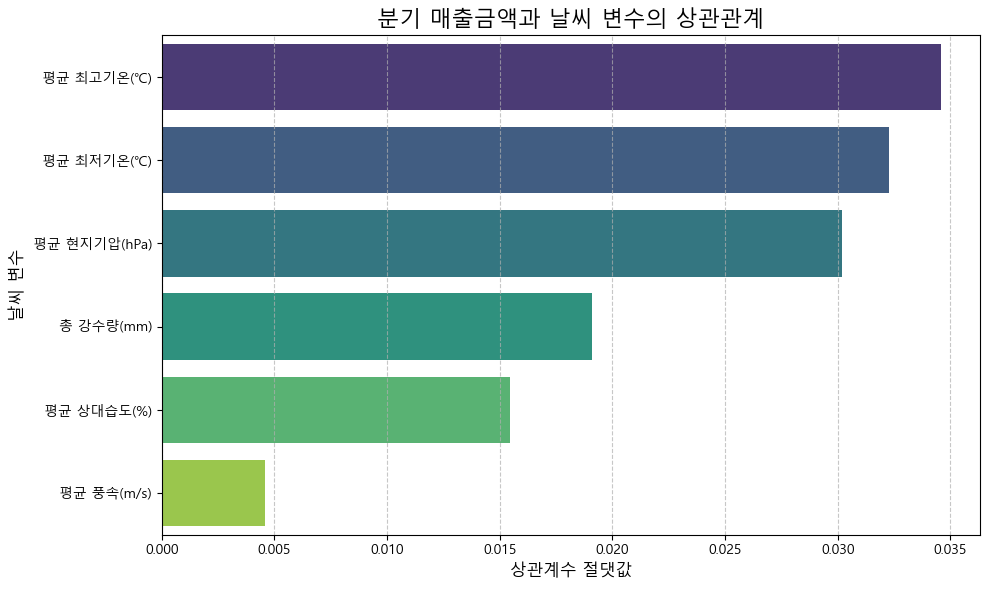

In [9]:
weather = [
    '평균 최저기온(℃)', '평균 최고기온(℃)', '총 강수량(mm)',
    '평균 풍속(m/s)', '평균 상대습도(%)', '평균 현지기압(hPa)'
]

# 1. 분기 매출금액과 날씨 변수들 간의 상관계수 계산
correlations = df[weather + ['분기_매출금액']].corr(method='pearson')
sales_corr = correlations['분기_매출금액'].drop('분기_매출금액') # 자기 자신은 제외

# 2. 절댓값 기준으로 정렬하여 관계가 강한 순으로 확인
strongest_corr = sales_corr.abs().sort_values(ascending=False)
strongest_corr_df = strongest_corr.to_frame(name='Correlation')

# 3. 상관관계 시각화 (막대 그래프)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=strongest_corr_df['Correlation'],
    y=strongest_corr_df.index,
    palette='viridis'
)

plt.title('분기 매출금액과 날씨 변수의 상관관계', fontsize=16)
plt.xlabel('상관계수 절댓값', fontsize=12)
plt.ylabel('날씨 변수', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

분기별로 날씨변수와 매출액과의 관계 파악

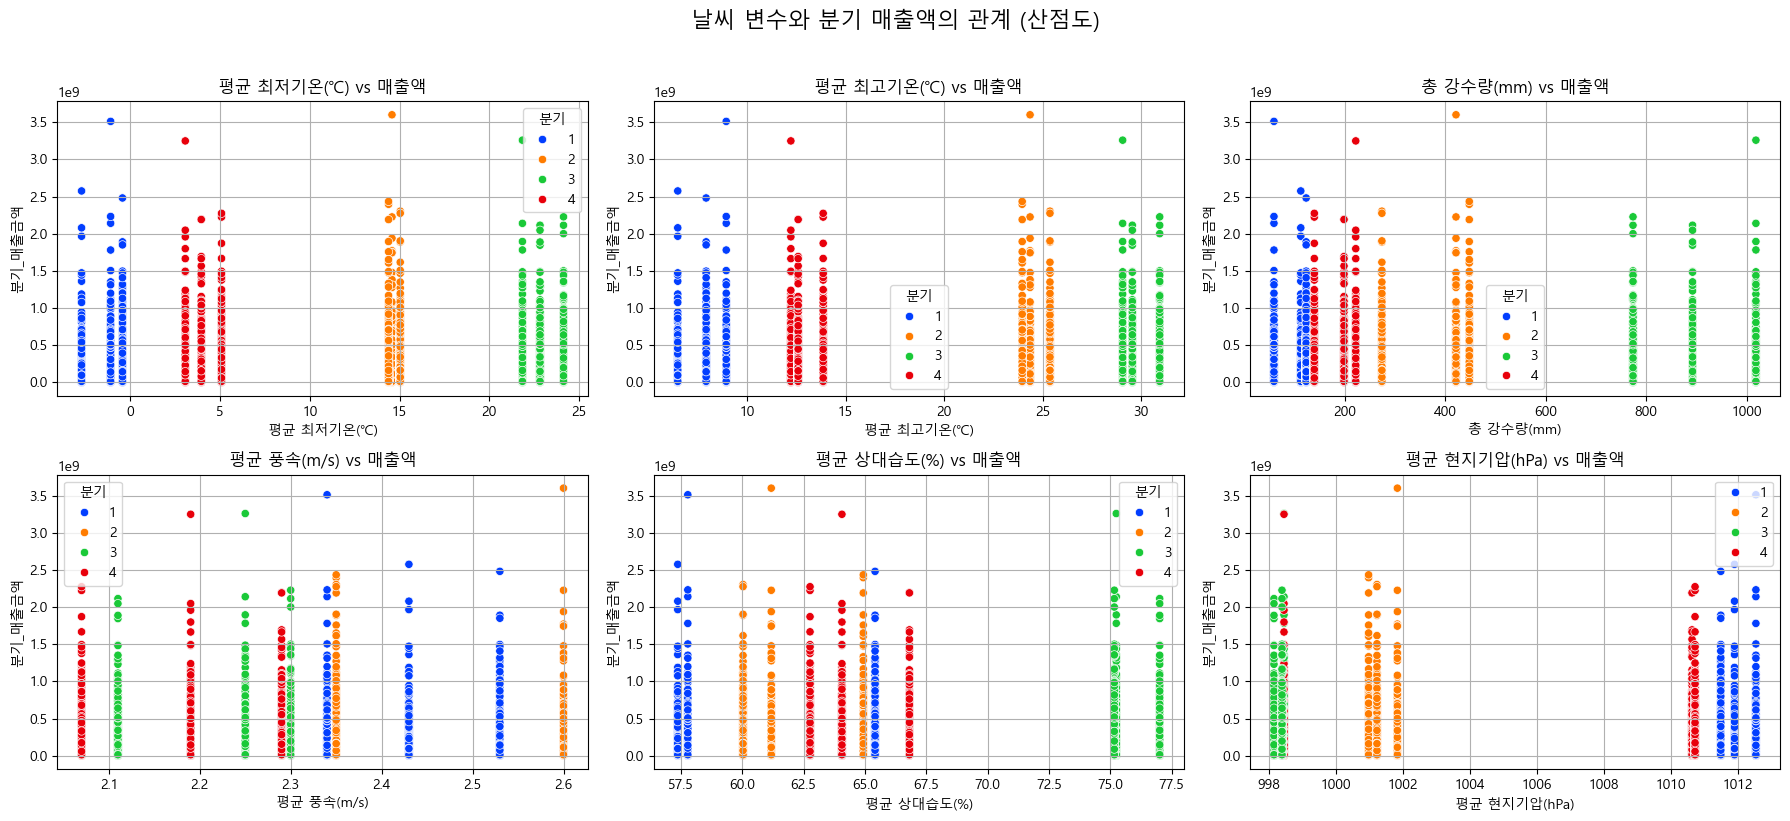

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle('날씨 변수와 분기 매출액의 관계 (산점도)', fontsize=16, y=1.02)

for i, col_name in enumerate(weather):
    row, col = i // 3, i % 3
    sns.scatterplot(ax=axes[row, col], data=df, x=col_name, y='분기_매출금액', hue='분기',palette='bright')
    axes[row, col].set_title(f'{col_name} vs 매출액')
    axes[row, col].grid(True)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

극단적인 매출값(Outlier)의 영향력을 최소화하기 위해, 각 분기별 매출액의 1사분위수(Q1)와 3사분위수(Q3)를 기준으로 IQR(Interquartile Range) 범위를 벗어나는 데이터를 제외하고 시각화

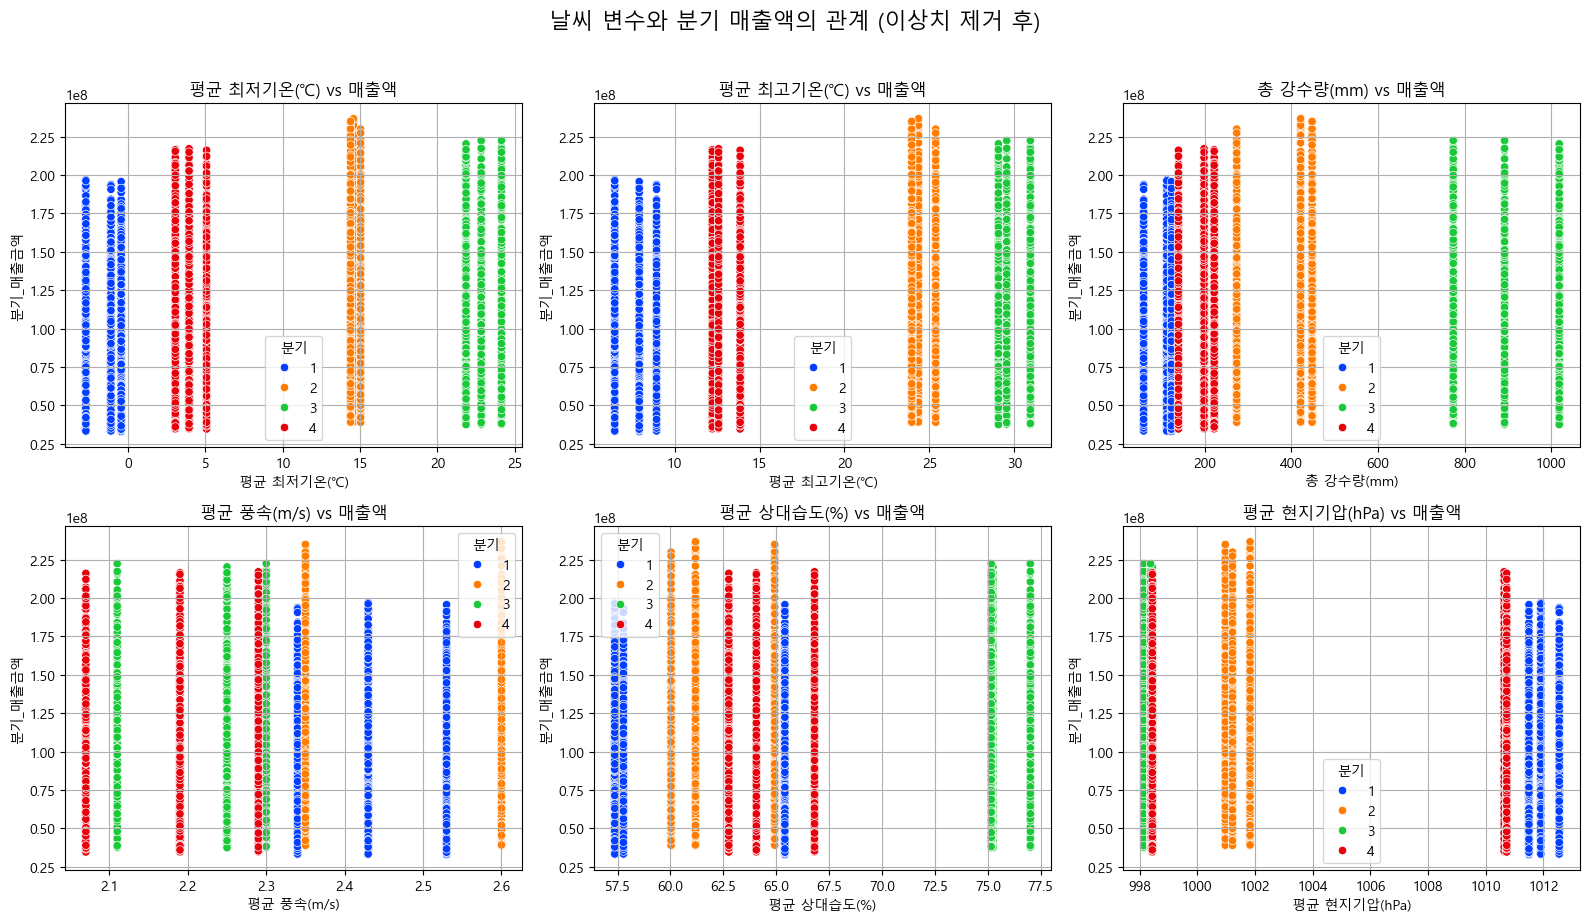

In [11]:
# 1. 분기별로 IQR을 사용하여 이상치 제거
filtered_data_list = []
for quarter in df['분기'].unique():
    quarter_df = df[df['분기'] == quarter]
    Q1 = quarter_df['분기_매출금액'].quantile(0.25)
    Q3 = quarter_df['분기_매출금액'].quantile(0.75)
    filtered_quarter_df = quarter_df[(quarter_df['분기_매출금액'] >= Q1) & (quarter_df['분기_매출금액'] <= Q3)]
    filtered_data_list.append(filtered_quarter_df)
df_filtered = pd.concat(filtered_data_list)

# 2. 이상치 제거 후 데이터 시각화
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('날씨 변수와 분기 매출액의 관계 (이상치 제거 후)', fontsize=16, y=1.02)

for i, col_name in enumerate(weather):
    row, col = i // 3, i % 3
    
    sns.scatterplot(
        ax=axes[row, col], 
        data=df_filtered, 
        x=col_name, 
        y='분기_매출금액', 
        hue='분기',
        palette='bright'
    )
    
    axes[row, col].set_title(f'{col_name} vs 매출액')
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

* 평균 최고기온(℃)  
    분석 결과, 평균 최고기온은 분기 매출액과 명확한 양의 상관관계를 나타냈다. 특히, 기온이 가장 낮은 1분기에 매출이 최저점을 기록하고, 기온이 상승함에 따라 매출액도 증가하는 뚜렷한 계절적 패턴이 확인되었다.

* 총 강수량(mm)  
    총 강수량은 분기 매출액과 직접적인 선형 관계는 약했지만, 여름철인 3분기에 데이터가 집중되는 뚜렷한 계절성을 나타냈다. 이는 강수량이 매출액에 간접적으로 영향을 미칠 가능성을 시사한다.  

단순한 기온 및 강수량 데이터 외에, 소비자의 체감 날씨를 나타내는 복합적인 변수를 생성하여 매출액과의 관계를 심층적으로 분석   
주어진 공식을 활용하여 '기온'과 '습구온도' 데이터를 기반으로 '불쾌지수' 파생변수를 생성  
(불쾌 지수 = 0.72 * (기온 + 습구온도) + 40.6)

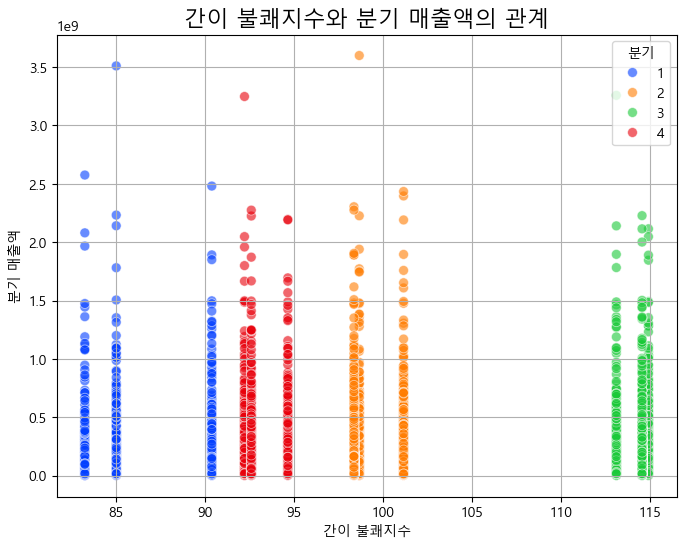

In [12]:
df['평균기온'] = (df['평균 최고기온(℃)'] + df['평균 최저기온(℃)']) / 2
df['불쾌지수_간이'] = 0.72 * (df['평균기온'] + df['평균 상대습도(%)']) + 40.6

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='불쾌지수_간이',
    y='분기_매출금액',
    hue='분기',          
    palette='bright',   
    alpha=0.6,         
    s=50                 
)

plt.title('간이 불쾌지수와 분기 매출액의 관계', fontsize=16)
plt.xlabel('간이 불쾌지수')
plt.ylabel('분기 매출액')
plt.grid(True)
plt.show()

이상치 제거하고 다시 시각화

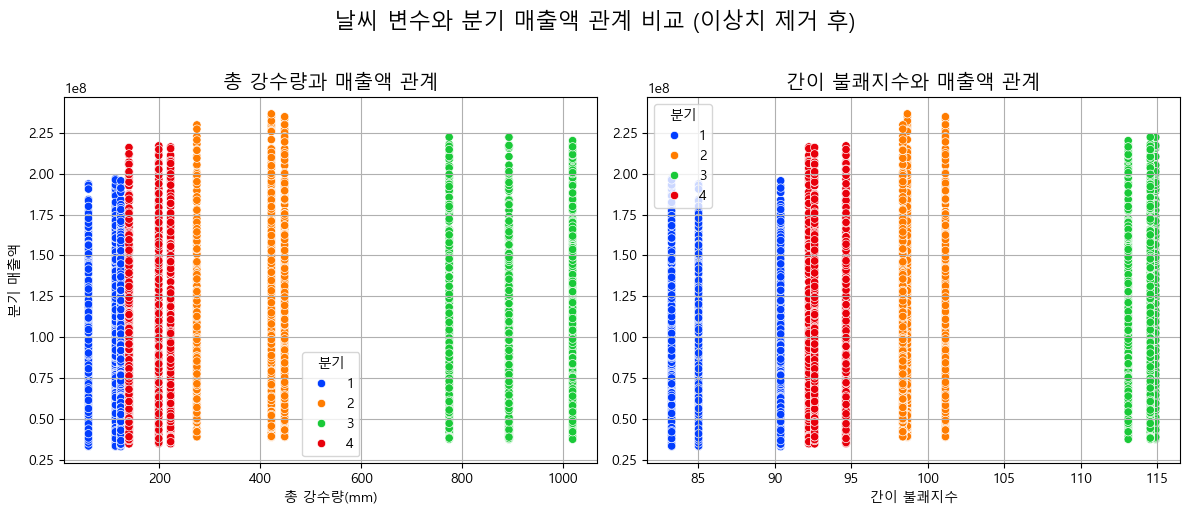

In [13]:
df['평균기온'] = (df['평균 최고기온(℃)'] + df['평균 최저기온(℃)']) / 2
df['불쾌지수_간이'] = 0.72 * (df['평균기온'] + df['평균 상대습도(%)']) + 40.6

# --- 분기별로 매출액의 1~3사분위수 데이터만 필터링 ---
filtered_data_list = []
for quarter in sorted(df['분기'].unique()):
    quarter_df = df[df['분기'] == quarter]
    Q1 = quarter_df['분기_매출금액'].quantile(0.25)
    Q3 = quarter_df['분기_매출금액'].quantile(0.75)
    filtered_quarter_df = quarter_df[(quarter_df['분기_매출금액'] >= Q1) & (quarter_df['분기_매출금액'] <= Q3)]
    filtered_data_list.append(filtered_quarter_df)
df_filtered = pd.concat(filtered_data_list)

# --- 그래프 비교 ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('날씨 변수와 분기 매출액 관계 비교 (이상치 제거 후)', fontsize=16, y=1.02)

# --- 왼쪽 그래프: 총 강수량 ---
sns.scatterplot(
    ax=axes[0],
    data=df_filtered,
    x='총 강수량(mm)',
    y='분기_매출금액',
    hue='분기',
    palette='bright'
)
axes[0].set_title('총 강수량과 매출액 관계', fontsize=14)
axes[0].set_xlabel('총 강수량(mm)')
axes[0].set_ylabel('분기 매출액')
axes[0].grid(True)

# --- 오른쪽 그래프: 간이 불쾌지수 ---
sns.scatterplot(
    ax=axes[1],
    data=df_filtered,
    x='불쾌지수_간이',
    y='분기_매출금액',
    hue='분기',
    palette='bright'
)
axes[1].set_title('간이 불쾌지수와 매출액 관계', fontsize=14)
axes[1].set_xlabel('간이 불쾌지수')
axes[1].set_ylabel('')
axes[1].grid(True)

plt.tight_layout()
plt.show()

강수량 변수와 간이 불쾌지수 간에 유의미한 분포 차이가 확인되지 않는다.

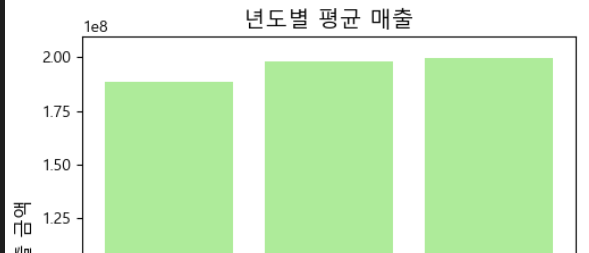

- 분석 배경
    연도별 평균 매출액이 전반적으로 지속적인 증가 추세를 보였다. 이는 물가 상승 또는 시장 규모 확대와 같은 복합적인 요인에 기인했을 가능성을 시사한다.

- 가설 설정
    물가 상승에 따른 명목적 증가: 매출액의 상승이 단순히 소비자물가지수(CPI) 상승에 따른 명목상의 증가일 가능성이 있다.

    실질적 시장 성장: 물가 상승률을 상회하는 전반적인 커피 소비량 증가에 따른 시장의 실질적 성장을 반영하는 것일 수 있다.

- 분석 방안
    소비자물가지수(CPI) 분석: 소비자물가지수를 활용한 실질 매출액 분석을 통해 물가 상승의 영향을 배제한 순수한 성장률을 파악할 수 있으나, 현재 분석 범위에서는 추가 연구 과제로 보류한다.

    커피 소비량 데이터 분석: 연도별 커피 소비량 데이터를 추가 확보하여 매출액과의 관계를 분석함으로써, 실질적인 시장 성장의 근거를 마련할 수 있으나, 이 또한 현재 분석 범위에서는 보류한다.

# 상권분석

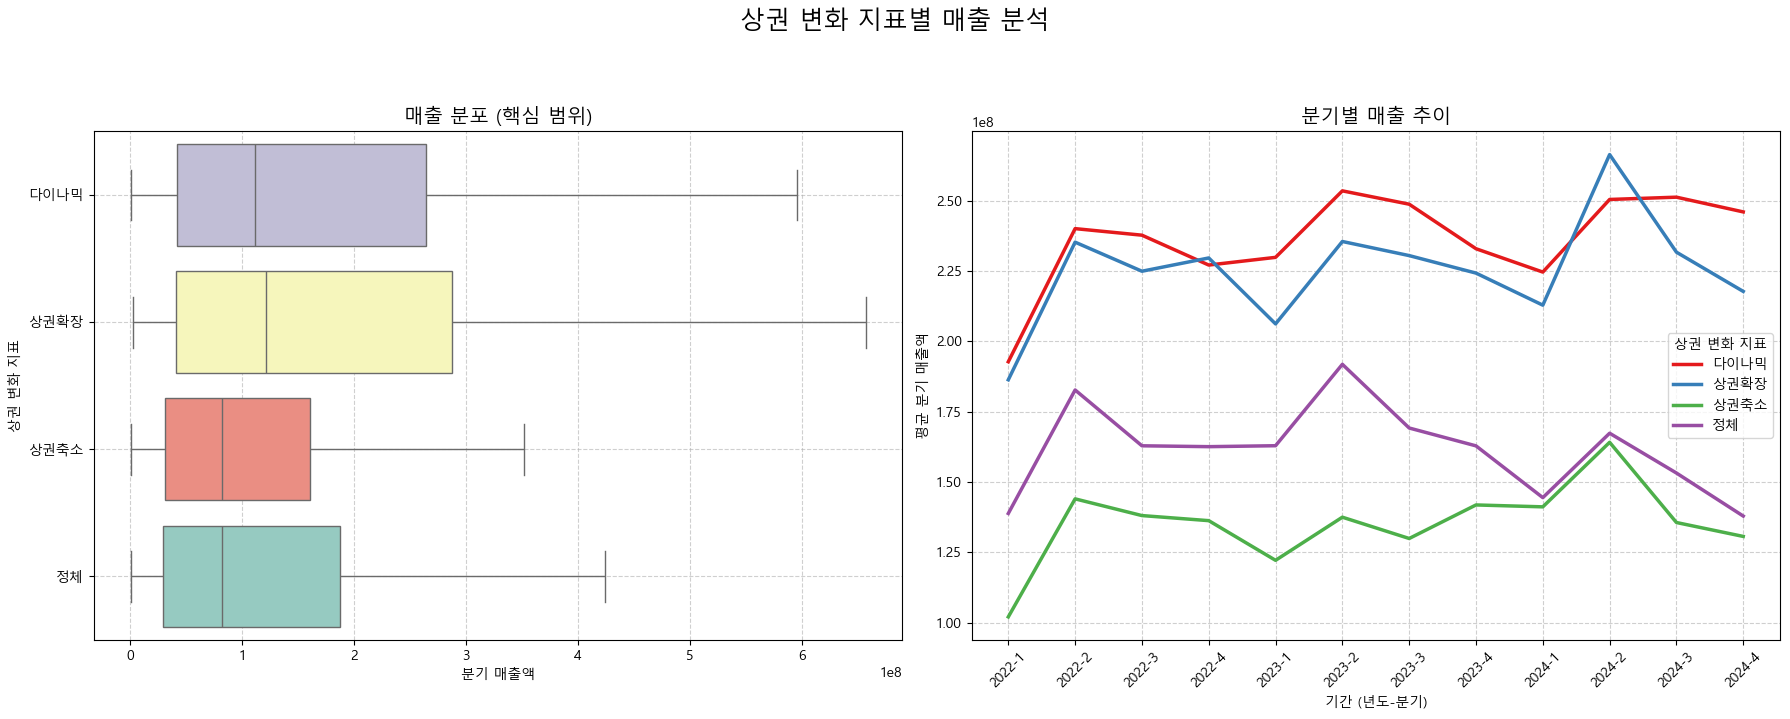

In [14]:
df['기간'] = df['년도'].astype(str) + '-' + df['분기'].astype(str)
df = df.sort_values(by=['년도', '분기'])

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('상권 변화 지표별 매출 분석', fontsize=18, y=1.02)

# 왼쪽 그래프: 매출 분포 (Box Plot)
sns.boxplot(
    ax=axes[0],
    data=df,
    y='상권_변화_지표_명',
    x='분기_매출금액',
    palette='Set3',
    order=['다이나믹', '상권확장', '상권축소', '정체'],
    hue='상권_변화_지표_명',
    showfliers=False,
    legend=False
)
axes[0].set_title('매출 분포 (핵심 범위)', fontsize=14)
axes[0].set_xlabel('분기 매출액')
axes[0].set_ylabel('상권 변화 지표')
axes[0].grid(True, linestyle='--', alpha=0.6)

# 오른쪽 그래프: 매출 추이 (Line Plot)
sns.lineplot(
    ax=axes[1],
    data=df,
    x='기간',
    y='분기_매출금액',
    hue='상권_변화_지표_명',
    hue_order=['다이나믹', '상권확장', '상권축소', '정체'],
    palette='Set1',
    linewidth=2.5,
    errorbar=None
)
axes[1].set_title('분기별 매출 추이', fontsize=14)
axes[1].set_xlabel('기간 (년도-분기)')
axes[1].set_ylabel('평균 분기 매출액')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend(title='상권 변화 지표')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

각 상권의 유형이 매출 수준을 구분하는 기준이 될 수 있음

<font size="2">상권확장 (LH): 새로운 가게들이 생기고, 한번 상권에 자리를 잡으면 평균적으로 오래가는 상권  
정체 (HH): 개업과 폐업이 모두 적어 변화가 거의 없는 안정적이거나 침체된 상권  
상권축소 (HL): 개업보다 폐업이 많아 쇠퇴하고 있는 위험 상권, 잘 되는 곳은 오래 버티지만, 한번 망하기 시작하면 빠르게 정리되는 상권  
다이나믹 (LL): 가게들이 쉽게 들어왔다가 쉽게 망해서 나가는,  기회와 위험이 공존하는 불안정한 상권  </font>

--- 운영/폐업 기간과 매출액의 상관관계 ---
운영_영업_개월_평균   -0.257692
폐업_영업_개월_평균   -0.046308
Name: 분기_매출금액, dtype: float64


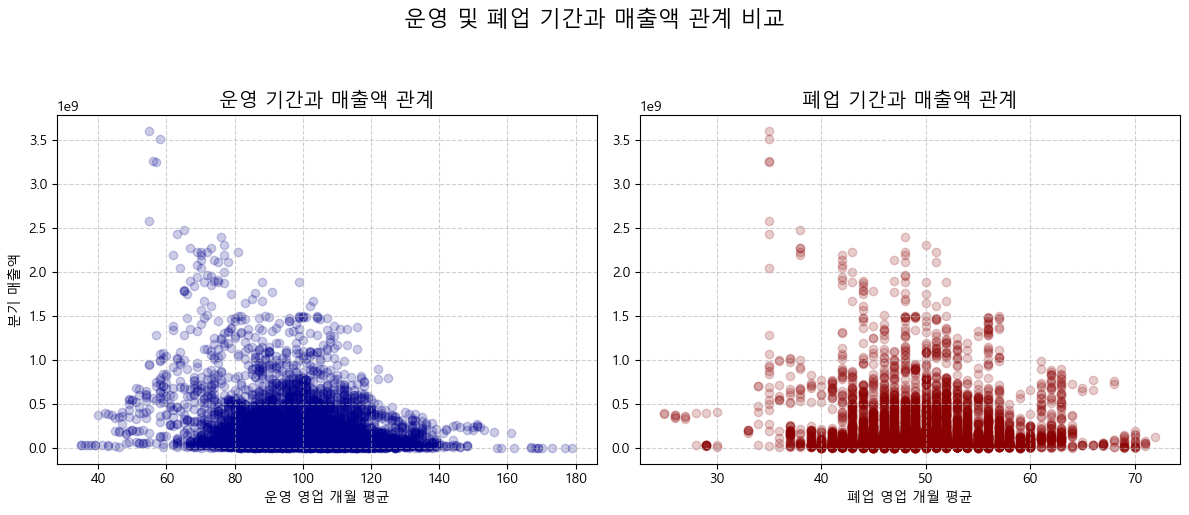

In [15]:
# 1. 상관관계 계산 및 출력
correlation = df[['운영_영업_개월_평균', '폐업_영업_개월_평균', '분기_매출금액']].corr()
print("--- 운영/폐업 기간과 매출액의 상관관계 ---")
print(correlation['분기_매출금액'][:2])

# 2. 1행 2열의 그래프 공간 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('운영 및 폐업 기간과 매출액 관계 비교', fontsize=16, y=1.02)

# --- 왼쪽 그래프: 운영 기간 vs 매출액 (산점도) ---
sns.regplot(
    ax=axes[0],
    data=df,
    x='운영_영업_개월_평균',
    y='분기_매출금액',
    scatter_kws={'alpha': 0.2, 'color': 'darkblue'},
    fit_reg=False
)
axes[0].set_title('운영 기간과 매출액 관계', fontsize=14)
axes[0].set_xlabel('운영 영업 개월 평균')
axes[0].set_ylabel('분기 매출액')
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- 오른쪽 그래프: 폐업 기간 vs 매출액 (산점도) ---
sns.regplot(
    ax=axes[1],
    data=df,
    x='폐업_영업_개월_평균',
    y='분기_매출금액',
    scatter_kws={'alpha': 0.2, 'color': 'darkred'},
    fit_reg=False
)
axes[1].set_title('폐업 기간과 매출액 관계', fontsize=14)
axes[1].set_xlabel('폐업 영업 개월 평균')
axes[1].set_ylabel('')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

운영 기간과 매출 관계  

현상: 운영 기간이 60~80개월인 상권에서 고수익 점포가 나타나지만, 100개월 이상인 '성숙기' 상권에서는 오히려 매출 상한선이 낮아지는 경향 

가설: 매장의 전성기에는 유통기한이 있음을 시사  
실행 방안: '운영_영업_개월_평균'을 구간으로 나누어, 새로운 카테고리형 변수를 생성하거나, 다른 변수와 조합하여 상권의 생애주기를 나타내는 지표로 활용  


폐업 기간과 매출 관계  

현상: 매출액과는 뚜렷한 선형 관계를 보이지 않음을 확인.

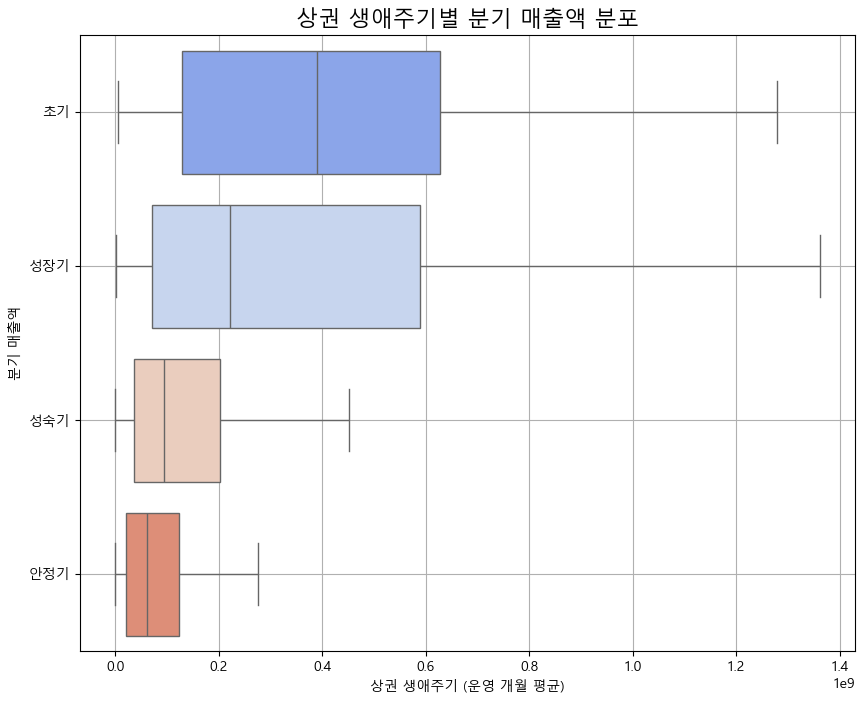

In [16]:
bins = [0, 60, 80, 120, float('inf')]
labels = ['초기', '성장기', '성숙기', '안정기']
df['상권_생애주기'] = pd.cut(df['운영_영업_개월_평균'], bins=bins, labels=labels, right=False)


# 2. 생성된 '상권_생애주기'를 기준으로 매출액 분포를 boxplot으로 시각화
plt.figure(figsize=(10, 8))
sns.boxplot(
    data=df,
    y='상권_생애주기',
    x='분기_매출금액',
    palette='coolwarm',
    showfliers=False
)

plt.title('상권 생애주기별 분기 매출액 분포', fontsize=16)
plt.xlabel('상권 생애주기 (운영 개월 평균)')
plt.ylabel('분기 매출액')
plt.grid(True)
plt.show()

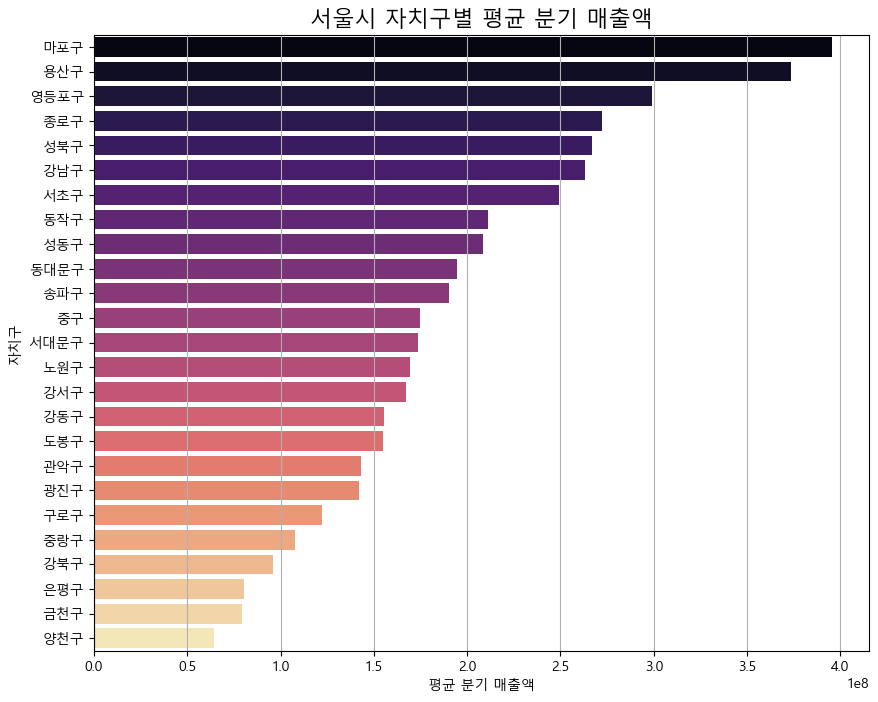

In [17]:
gu_sales_sorted = df.groupby('자치구')['분기_매출금액'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=gu_sales_sorted.values,
    y=gu_sales_sorted.index,
    palette='magma'
)

plt.title('서울시 자치구별 평균 분기 매출액', fontsize=16)
plt.xlabel('평균 분기 매출액')
plt.ylabel('자치구')
plt.grid(axis='x') # x축에만 그리드 표시
plt.show()

현상: 자치구별로 매출 규모에서 차이가 나타나는 것을 확인.

가설: 이러한 차이는 각 자치구가 가진 고유한 특성(예: 랜드마크, 지역 문화, 주요 산업)에서 비롯되며, 이 특성들이 종합되어 상권의 등급을 형성할 것으로 추정.

실행 방안: 각 자치구의 평균 매출액, 상권의 종류에 대한 비율 등을 종합적으로 고려하여 상권 등급이라는 새로운 파생변수를 생성. 이 변수를 원-핫 인코딩하여 모델에 활용함으로써 지역별 격차를 효과적으로 반영.

In [18]:
gu_sales_rank = df.groupby('자치구')['분기_매출금액'].mean().sort_values(ascending=False)

quantiles = gu_sales_rank.quantile([0.3, 0.7]).to_dict()
tier_low = quantiles[0.3]
tier_high = quantiles[0.7]

def assign_tier(gu_name):
    avg_sale = gu_sales_rank.loc[gu_name]
    if avg_sale >= tier_high:
        return '상위'
    elif avg_sale < tier_low:
        return '하위'
    else:
        return '중위'


df['상권_등급'] = df['자치구'].apply(assign_tier)

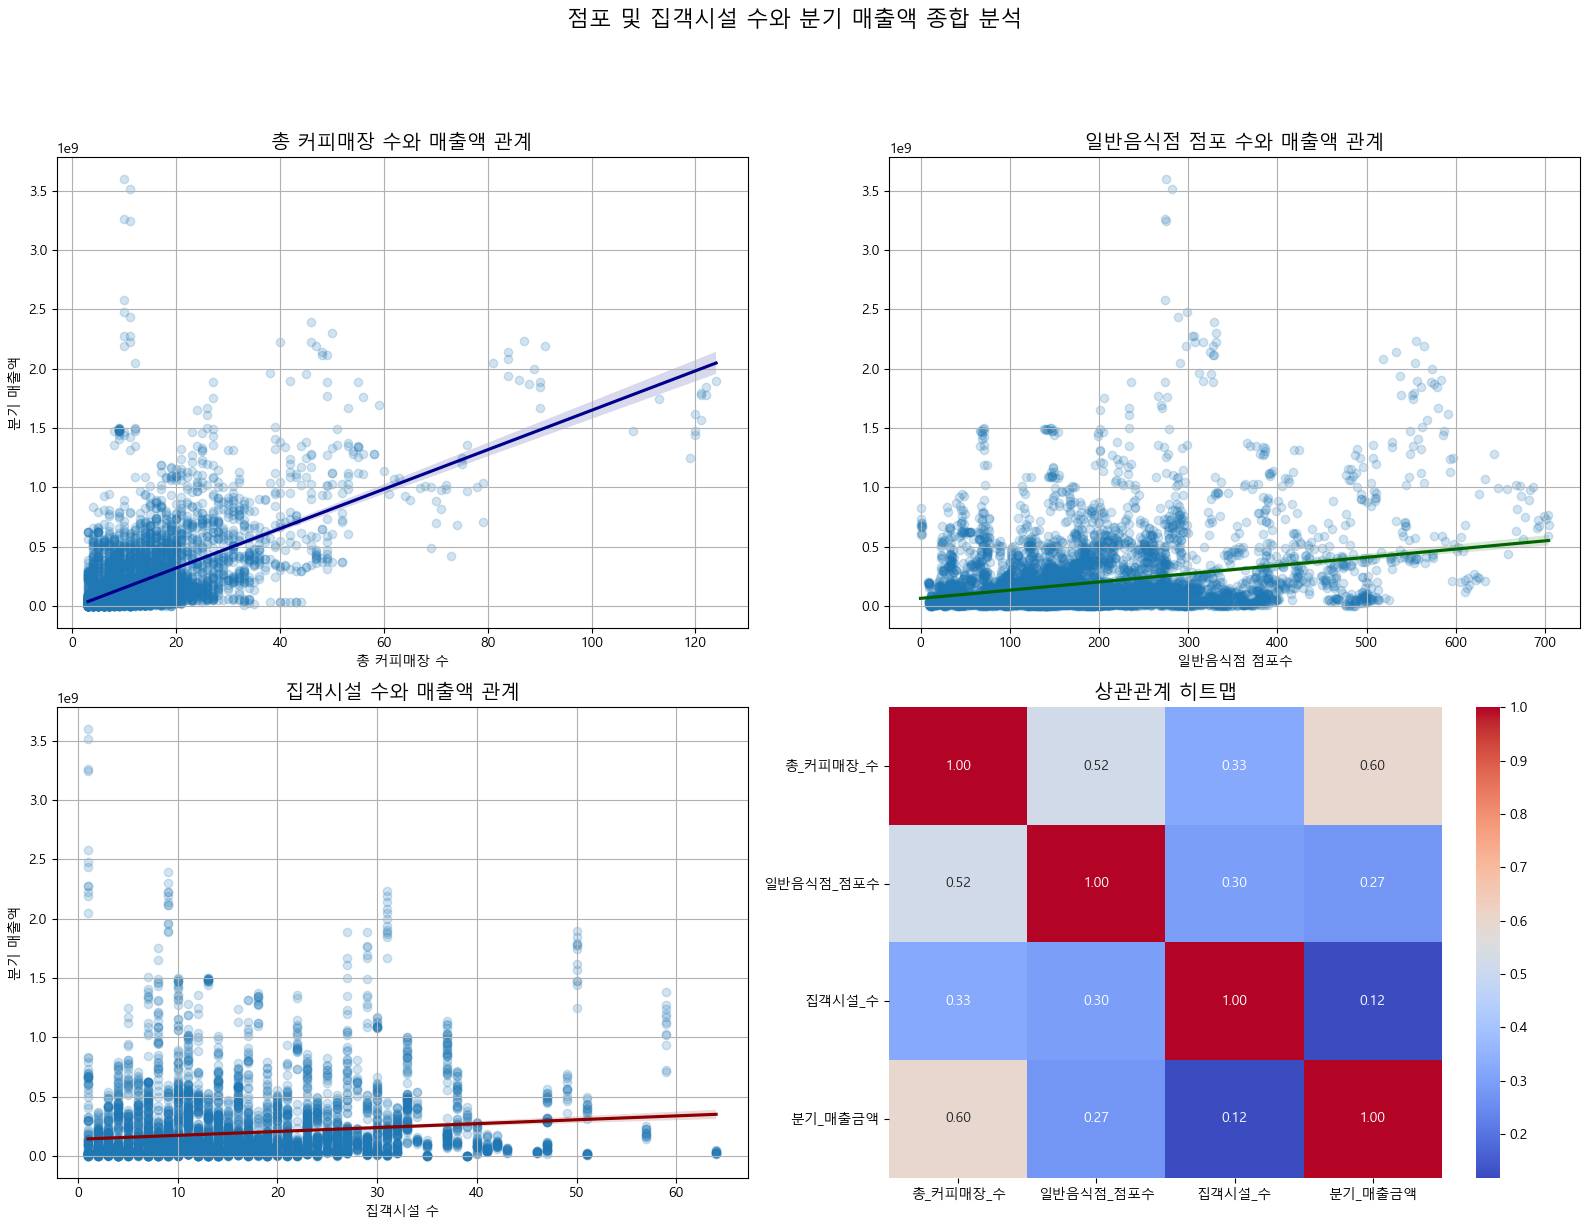

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('점포 및 집객시설 수와 분기 매출액 종합 분석', fontsize=16, y=1.02)


# --- 1행 1열: 총 커피매장 수 vs 매출액 ---
sns.regplot(
    ax=axes[0, 0],
    data=df,
    x='총_커피매장_수',
    y='분기_매출금액',
    scatter_kws={'alpha': 0.2},
    line_kws={'color': 'darkblue'}
)
axes[0, 0].set_title('총 커피매장 수와 매출액 관계', fontsize=14)
axes[0, 0].set_xlabel('총 커피매장 수')
axes[0, 0].set_ylabel('분기 매출액')
axes[0, 0].grid(True)


# --- 1행 2열: 일반음식점 점포 수 vs 매출액 ---
sns.regplot(
    ax=axes[0, 1],
    data=df,
    x='일반음식점_점포수',
    y='분기_매출금액',
    scatter_kws={'alpha': 0.2},
    line_kws={'color': 'darkgreen'}
)
axes[0, 1].set_title('일반음식점 점포 수와 매출액 관계', fontsize=14)
axes[0, 1].set_xlabel('일반음식점 점포수')
axes[0, 1].set_ylabel('')
axes[0, 1].grid(True)


# --- 2행 1열: 집객시설 수 vs 매출액 ---
sns.regplot(
    ax=axes[1, 0],
    data=df,
    x='집객시설_수',
    y='분기_매출금액',
    scatter_kws={'alpha': 0.2},
    line_kws={'color': 'darkred'}
)
axes[1, 0].set_title('집객시설 수와 매출액 관계', fontsize=14)
axes[1, 0].set_xlabel('집객시설 수')
axes[1, 0].set_ylabel('분기 매출액')
axes[1, 0].grid(True)


# --- 2행 2열: 상관관계 히트맵 ---
analysis_cols = ['총_커피매장_수', '일반음식점_점포수', '집객시설_수', '분기_매출금액']
correlation_matrix = df[analysis_cols].corr()
sns.heatmap(
    ax=axes[1, 1],
    data=correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
axes[1, 1].set_title('상관관계 히트맵', fontsize=14)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

세 변수 모두 매출액과 양의 상관관계가 있음

# 상주인구

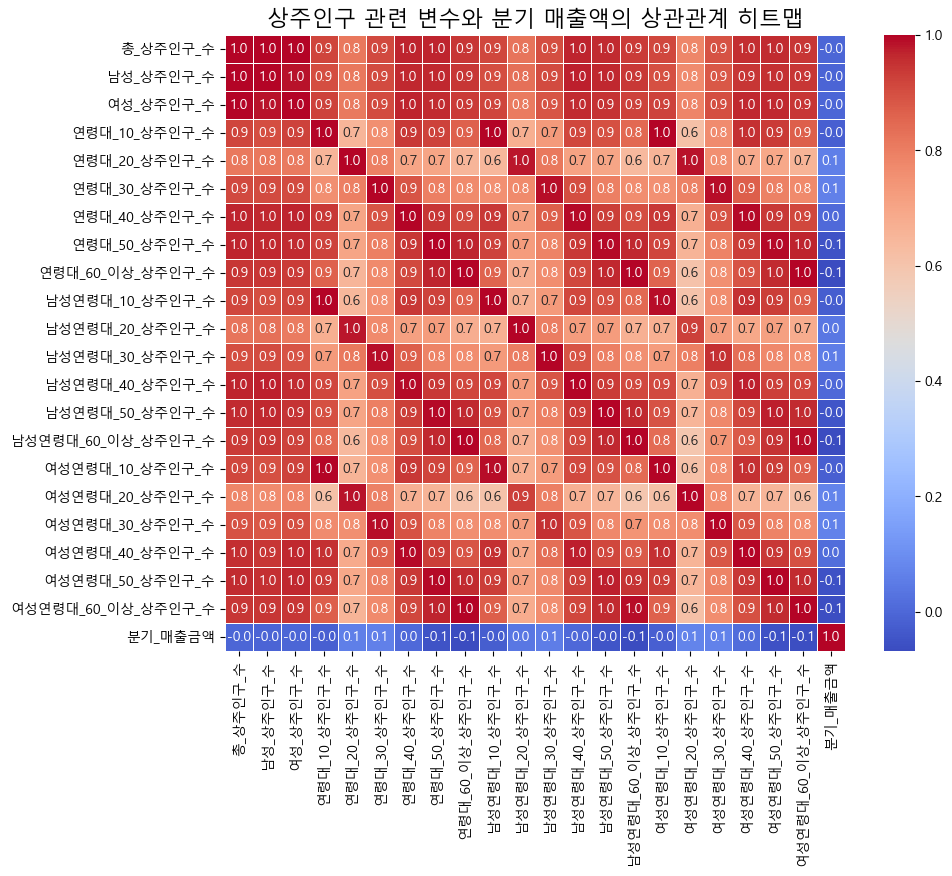

In [20]:
resident_features = [
    '총_상주인구_수',
    '남성_상주인구_수',
    '여성_상주인구_수',
    '연령대_10_상주인구_수',
    '연령대_20_상주인구_수',
    '연령대_30_상주인구_수',
    '연령대_40_상주인구_수',
    '연령대_50_상주인구_수',
    '연령대_60_이상_상주인구_수',
    '남성연령대_10_상주인구_수',
    '남성연령대_20_상주인구_수',
    '남성연령대_30_상주인구_수',
    '남성연령대_40_상주인구_수',
    '남성연령대_50_상주인구_수',
    '남성연령대_60_이상_상주인구_수',
    '여성연령대_10_상주인구_수',
    '여성연령대_20_상주인구_수',
    '여성연령대_30_상주인구_수',
    '여성연령대_40_상주인구_수',
    '여성연령대_50_상주인구_수',
    '여성연령대_60_이상_상주인구_수',
]

correlation_matrix = df[resident_features + ['분기_매출금액']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,       
    cmap='coolwarm',  
    fmt='.1f',       
    linewidths=.5
)
plt.title('상주인구 관련 변수와 분기 매출액의 상관관계 히트맵', fontsize=16)
plt.show()

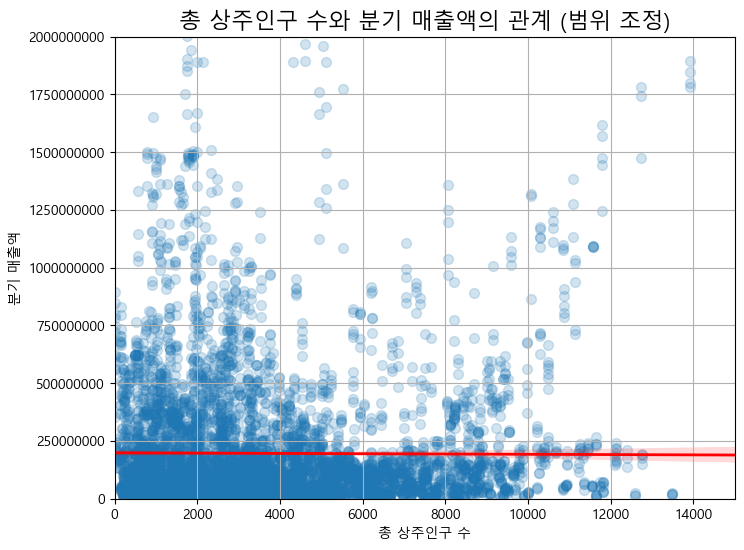

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.regplot(
    ax=ax,
    data=df,
    x='총_상주인구_수',
    y='분기_매출금액',
    scatter_kws={'alpha': 0.2, 's': 50},
    line_kws={'color': 'red', 'linewidth': 2}
)


ax.set_xlim(0, 15000)
ax.set_ylim(0, 2 * 1e9)
# ----------------------------------------

# 그래프 제목 및 라벨 설정
ax.set_title('총 상주인구 수와 분기 매출액의 관계 (범위 조정)', fontsize=16)
ax.set_xlabel('총 상주인구 수')
ax.set_ylabel('분기 매출액')
ax.grid(True)

# y축 지수 표기법 해제
ax.ticklabel_format(style='plain', axis='y')

plt.show()

현상: '총 상주인구 수'와 '분기 매출액' 간에는 뚜렷한 선형 관계가 관찰되지 않았다. 그러나 데이터 분포를 통해 시장 성격에 대한 패턴을 발견할 수 있었다.

가설: 상주인구 수에 따라 시장의 특성이 달라질 것이다. 상주인구가 적은 지역은 안정적인 저수익 시장이며, 상주인구가 많은 지역은 변동성이 큰 고위험 고수익 시장일 가능성이 높다.

실행 방안: 상주인구 수를 기준으로 데이터를 구간별로 나누어 분석한다. 이를 통해 상주인구가 적은 구간(0~5,000명)은 매출액이 좁고 낮은 범위에 밀집되어 있는 '저위험-저수익' 시장으로, 상주인구가 많은 구간(5,000명 이상)은 매출액이 넓은 범위에 분포하는 '고위험-고수익' 시장으로 시장 성격을 분류한다. 이 결과를 바탕으로 상주인구 변수를 매출 예측에 직접적으로 활용하기보다는, 시장의 성격을 규정하고 위험도를 분석하는 중요한 변수로 활용한다.

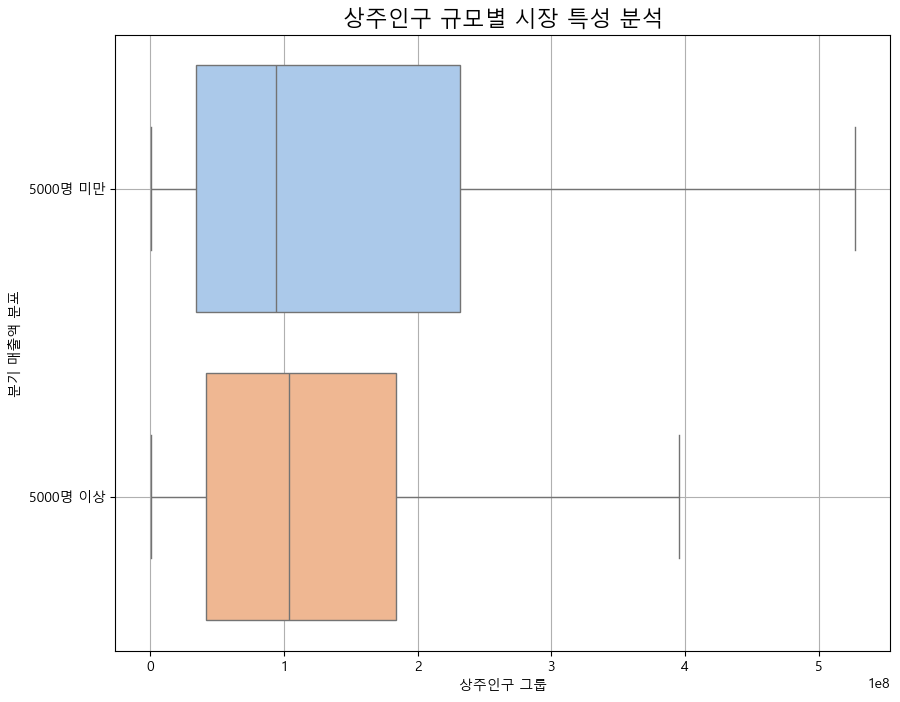

In [22]:
df['상주인구_그룹'] = np.where(df['총_상주인구_수'] < 5000, '5000명 미만', '5000명 이상')

# . 생성된 그룹을 기준으로 매출액 분포를 boxplot으로 시각화
plt.figure(figsize=(10, 8))
sns.boxplot(
    data=df,
    y='상주인구_그룹',
    x='분기_매출금액',
    palette='pastel',
    showfliers=False  # 이상치를 제외하고 핵심 분포에 집중
)

plt.title('상주인구 규모별 시장 특성 분석', fontsize=16)
plt.xlabel('상주인구 그룹')
plt.ylabel('분기 매출액 분포')
plt.grid(True)
plt.show()

5000명 기준으로 나누는 것은 크게 의미가 있어 보이지 않음

# 직장인구

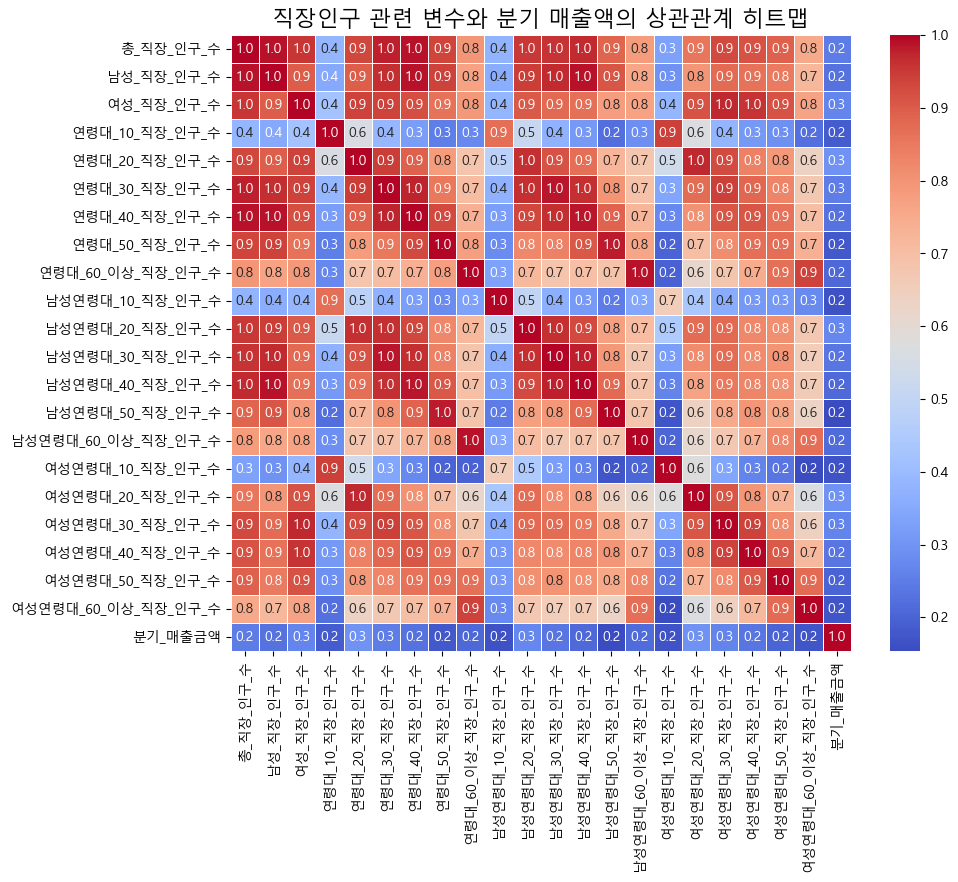

In [23]:
work_features = [
    '총_직장_인구_수', '남성_직장_인구_수', '여성_직장_인구_수',
    '연령대_10_직장_인구_수', '연령대_20_직장_인구_수', '연령대_30_직장_인구_수',
    '연령대_40_직장_인구_수', '연령대_50_직장_인구_수', '연령대_60_이상_직장_인구_수',
    '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
    '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
    '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
    '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수',
]
correlation_matrix = df[work_features + ['분기_매출금액']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.1f',
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('직장인구 관련 변수와 분기 매출액의 상관관계 히트맵', fontsize=16)
plt.show()

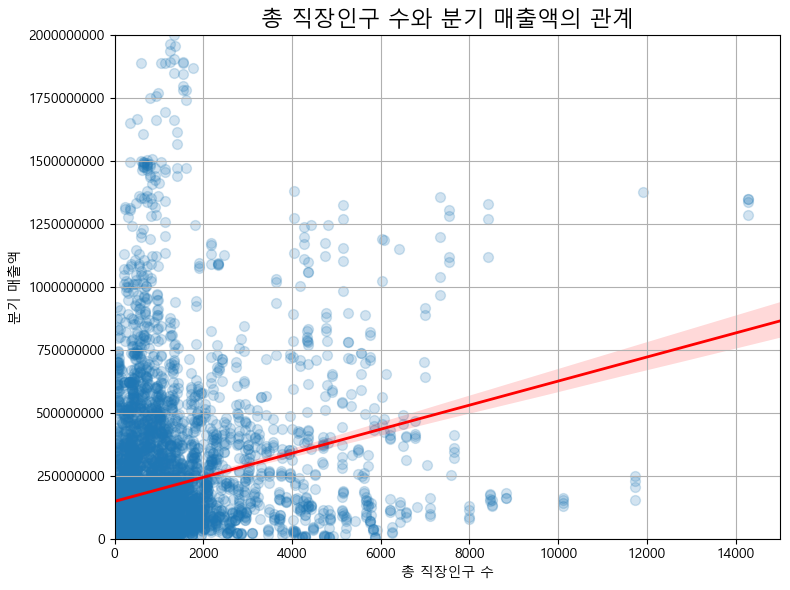

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.regplot(
    ax=ax,
    data=df,
    x='총_직장_인구_수',
    y='분기_매출금액',
    scatter_kws={'alpha': 0.2, 's': 50},  
    line_kws={'color': 'red', 'linewidth': 2} 
)

ax.set_xlim(0, 15000)
ax.set_ylim(0, 2 * 1e9)

ax.set_title('총 직장인구 수와 분기 매출액의 관계', fontsize=16)
ax.set_xlabel('총 직장인구 수')
ax.set_ylabel('분기 매출액')
ax.grid(True)

ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

현상: '총 직장인구 수'와 '분기 매출액' 간에는 뚜렷한 선형 관계가 나타나지 않았으나, 구간별 데이터 분포를 통해 시장 특성을 해석할 수 있었다.

가설: 직장인구 수에 따라 시장의 위험도와 수익성이 달라질 것이다. 직장인구가 적은 지역은 안정적인 저수익 시장이며, 직장인구가 많은 지역은 변동성이 큰 고위험-고수익 시장일 가능성이 높다.

실행 방안: 직장인구 수를 기준으로 데이터를 구간별로 나누어 분석한다. 직장인구가 4,000명 미만인 지역은 매출이 낮고 변동폭이 적은 '저위험-저수익' 시장으로 분류한다. 반면, 직장인구가 4,000명 이상인 지역은 매출 수준이 매우 다양하여 '고위험-고수익' 시장의 특성을 가진 것으로 분석한다. 이 변수는 매출 예측에 직접적인 영향은 약할 수 있으나, 시장의 성격을 규정하고 위험도를 분석하는 중요한 변수로 활용한다.

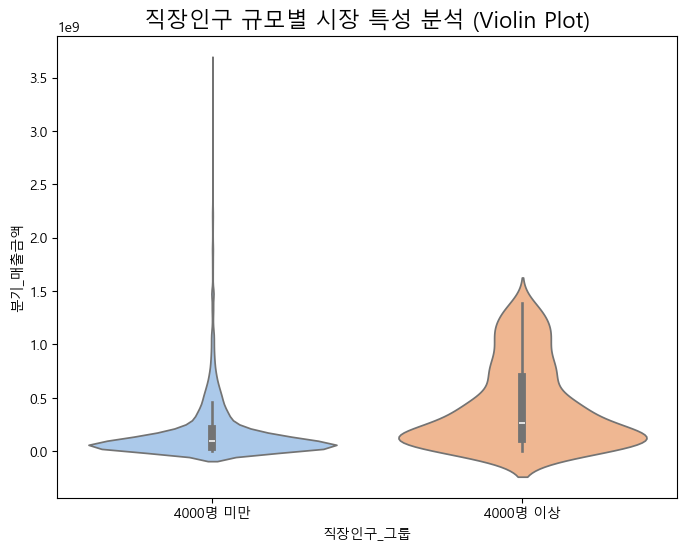

In [25]:
df['직장인구_그룹'] = np.where(df['총_직장_인구_수'] < 4000, '4000명 미만', '4000명 이상')

plt.figure(figsize=(8, 6))
sns.violinplot(
    data=df,
    x='직장인구_그룹',
    y='분기_매출금액',
    palette='pastel'
)
plt.title('직장인구 규모별 시장 특성 분석 (Violin Plot)', fontsize=16)
plt.show()

4000명을 기준으로 시장의 성격 파악 가능하여 독립변수로 적절해보임

# 유동인구

In [26]:
# 전체 유동인구
base = ['총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수']

# 연령대
age = [
    '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수',
    '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수'
]

# 시간대
time = [
    '시간대_00_06_유동인구_수', '시간대_06_11_유동인구_수', '시간대_11_14_유동인구_수',
    '시간대_14_17_유동인구_수', '시간대_17_21_유동인구_수', '시간대_21_24_유동인구_수'
]

# 요일별
weekday = [
    '월요일_유동인구_수', '화요일_유동인구_수', '수요일_유동인구_수',
    '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수'
]

floating_features = base + age + time + weekday


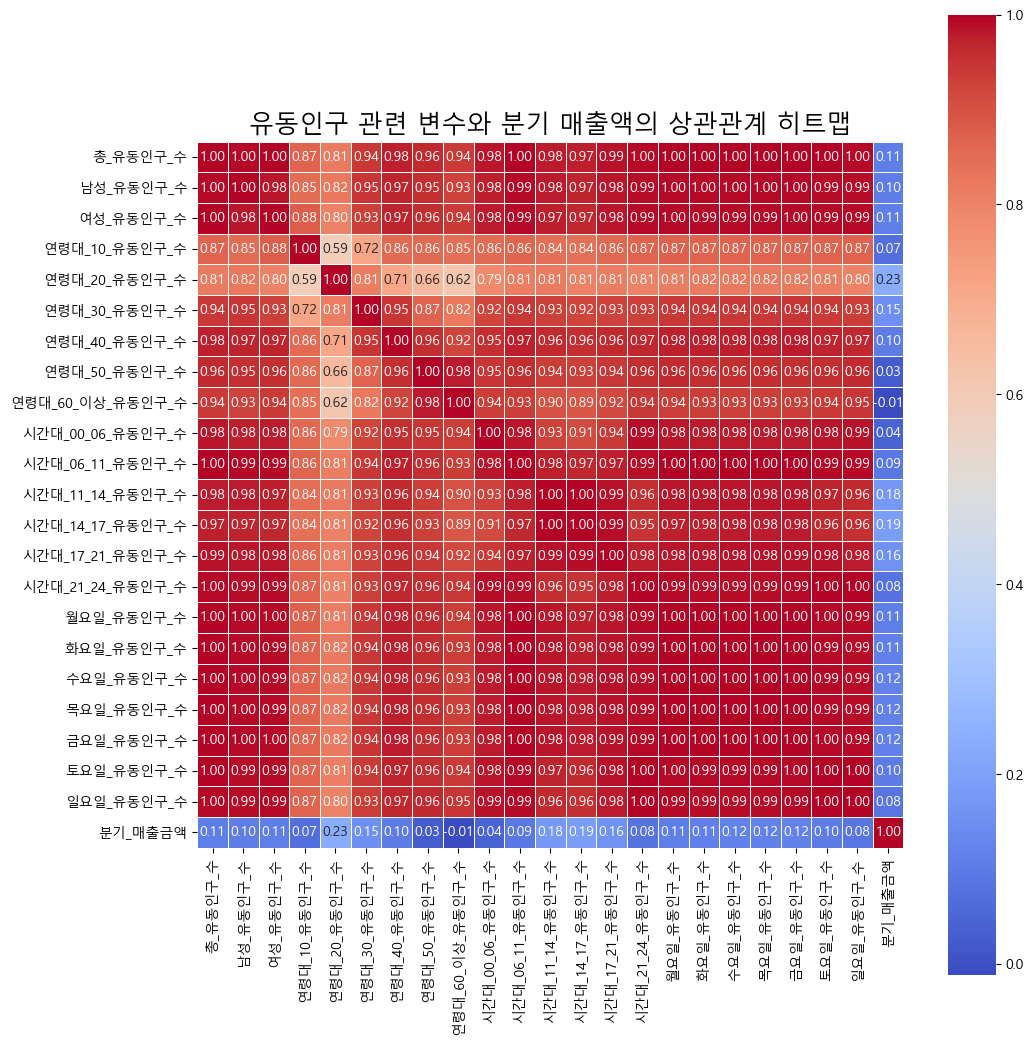

In [27]:
correlation_matrix = df[floating_features + ['분기_매출금액']].corr()

plt.figure(figsize=(11, 11))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',           # 소수점 두 자리
    cmap='coolwarm',
    linewidths=0.5,
    square=True          # 정사각형 셀 유지
)

plt.title('유동인구 관련 변수와 분기 매출액의 상관관계 히트맵', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



1. 연령대별 유동인구
   현상: 연령대별 유동인구가 매출에 미치는 영향이 다름을 확인.

   가설: 특히 20~40대 유동인구가 핵심 소비층으로 작용할 것으로 추정.

   실행 방안: 유동인구 데이터를 **'20~40대'**와 **'그 외 연령대'**로 그룹화하여 새로운 파생변수를 생성하고, 모델에 활용.

2. 시간대별 유동인구
   현상: 시간대별 유동인구가 매출에 미치는 영향이 다름을 확인.

   가설: 주요 소비 활동이 일어나는 피크 시간대(11시~21시)의 유동인구가 매출과 더 강한 관계를 보일 것으로 추정.

   실행 방안: 유동인구 데이터를 **'피크 시간대'**와 **'그 외 시간대'**로 나누어 파생변수를 생성하고, 모델에 활용.

3. 요일별 유동인구
   현상: 요일별 유동인구는 매출과의 상관계수에서 큰 차이를 보이지 않음.

   가설: 개별 요일 변수는 매출 예측에 큰 변별력을 가지지 못할 것으로 판단.

   실행 방안: 요일별 변수는 모델의 복잡성을 고려하여 제거  

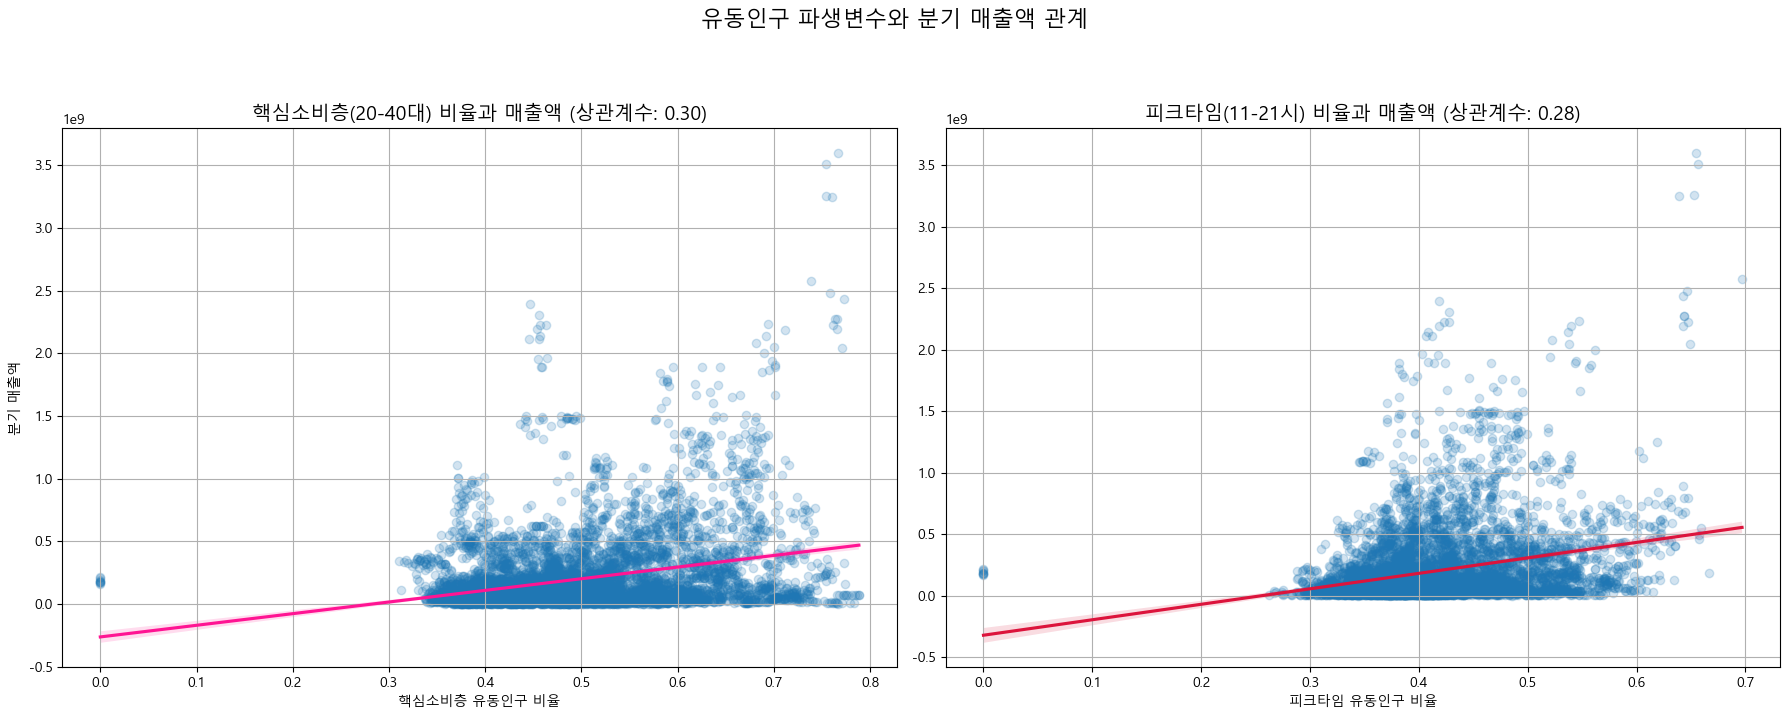

In [28]:
core_age_cols = ['연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수']
df['핵심소비층_유동인구_수'] = df[core_age_cols].sum(axis=1)
df['핵심소비층_비율'] = (df['핵심소비층_유동인구_수'] / df['총_유동인구_수']).fillna(0)


#  '피크타임 비율' 파생변수 생성 ---
peak_time_cols = ['시간대_11_14_유동인구_수', '시간대_14_17_유동인구_수', '시간대_17_21_유동인구_수']
df['피크타임_유동인구_수'] = df[peak_time_cols].sum(axis=1)
df['피크타임_비율'] = (df['피크타임_유동인구_수'] / df['총_유동인구_수']).fillna(0)


fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('유동인구 파생변수와 분기 매출액 관계', fontsize=16, y=1.02)

corr1 = df['핵심소비층_비율'].corr(df['분기_매출금액'])
sns.regplot(
    ax=axes[0],
    data=df,
    x='핵심소비층_비율',
    y='분기_매출금액',
    scatter_kws={'alpha': 0.2},
    line_kws={'color': 'deeppink'}
)
axes[0].set_title(f'핵심소비층(20-40대) 비율과 매출액 (상관계수: {corr1:.2f})', fontsize=14)
axes[0].set_xlabel('핵심소비층 유동인구 비율')
axes[0].set_ylabel('분기 매출액')
axes[0].grid(True)


# --- 오른쪽 그래프: 피크타임 비율 vs 매출액 ---
corr2 = df['피크타임_비율'].corr(df['분기_매출금액'])
sns.regplot(
    ax=axes[1],
    data=df,
    x='피크타임_비율',
    y='분기_매출금액',
    scatter_kws={'alpha': 0.2},
    line_kws={'color': 'crimson'}
)
axes[1].set_title(f'피크타임(11-21시) 비율과 매출액 (상관계수: {corr2:.2f})', fontsize=14)
axes[1].set_xlabel('피크타임 유동인구 비율')
axes[1].set_ylabel('')
axes[1].grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

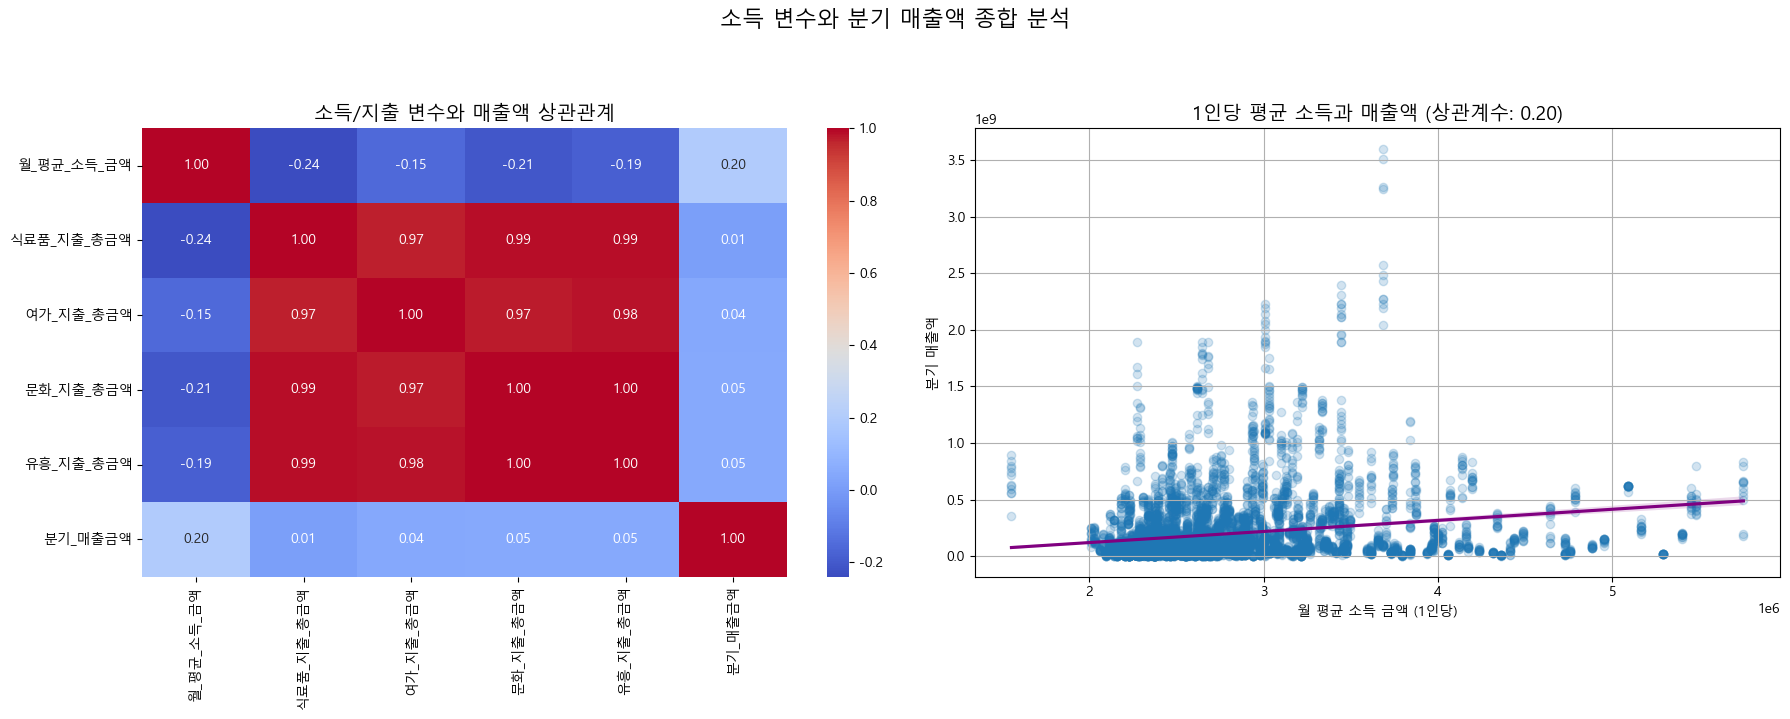

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('소득 변수와 분기 매출액 종합 분석', fontsize=16, y=1.02)


# --- 왼쪽 그래프: 상관관계 히트맵 ---
income_spending_cols = [
    '월_평균_소득_금액', '식료품_지출_총금액', '여가_지출_총금액',
    '문화_지출_총금액', '유흥_지출_총금액', '분기_매출금액'
]
correlation_matrix = df[income_spending_cols].corr()
sns.heatmap(
    ax=axes[0],
    data=correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
axes[0].set_title('소득/지출 변수와 매출액 상관관계', fontsize=14)


# --- 오른쪽 그래프: 1인당 평균 소득 vs 매출액 ---
corr1 = df['월_평균_소득_금액'].corr(df['분기_매출금액'])
sns.regplot(
    ax=axes[1],
    data=df,
    x='월_평균_소득_금액',
    y='분기_매출금액',
    scatter_kws={'alpha': 0.2},
    line_kws={'color': 'purple'}
)
axes[1].set_title(f'1인당 평균 소득과 매출액 (상관계수: {corr1:.2f})', fontsize=14)
axes[1].set_xlabel('월 평균 소득 금액 (1인당)')
axes[1].set_ylabel('분기 매출액')
axes[1].grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

상관관계가 가장 높은 월_평균_소득_금액 하나만 대표로 사용하고, 나머지 지출 변수들은 모두 제거

# 자치구를 기준으로 해당 지역의 직장인 인구수와 유동인구수 파악

직장인 유동인구수가 많은지역(오피스 지역)과 카페 매출간의 관계 파악

In [30]:
df_gu_quarterly = df.groupby(['자치구', '년도', '분기']).agg({
    '총_직장_인구_수': 'sum',
    '분기_매출금액': 'sum'
}).reset_index()

자치구별 직장인 인구 수 막대 그래프를 'workers_by_gu_barchart.png'로 저장했습니다.
직장인 인구와 매출 관계 산점도를 'sales_vs_workers_scatterplot.png'로 저장했습니다.


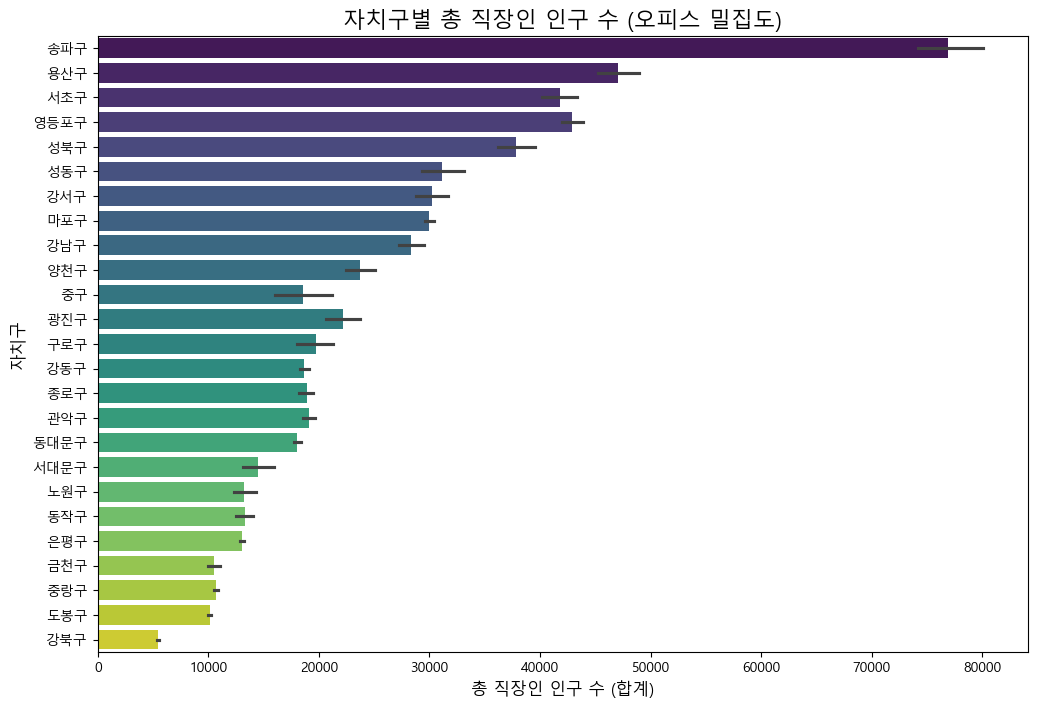

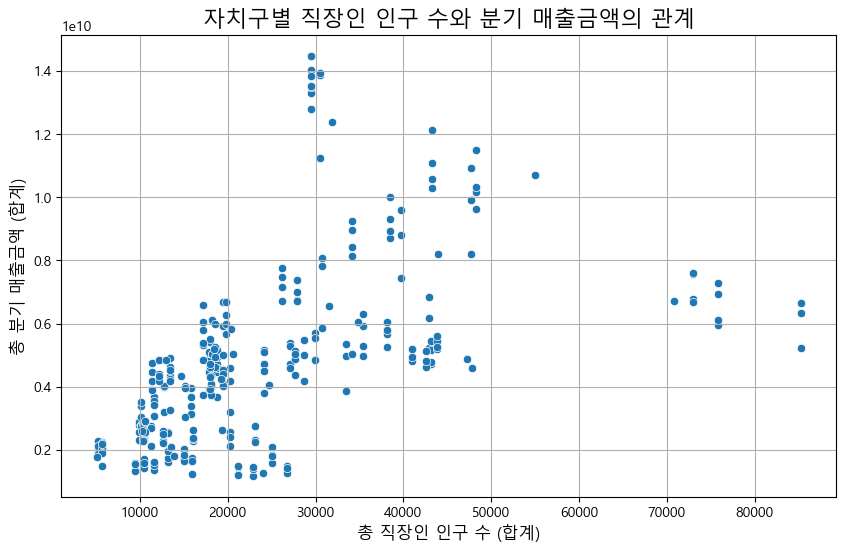

In [31]:
# --- 5. 자치구별 직장인 인구 수 시각화 (막대 그래프) ---
# 직장인 인구 수로 내림차순 정렬하여 어떤 구가 가장 많은지 확인합니다.
df_gu_sorted = df_gu_quarterly.sort_values(by='총_직장_인구_수', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='총_직장_인구_수', y='자치구', data=df_gu_sorted, palette='viridis')
plt.title('자치구별 총 직장인 인구 수 (오피스 밀집도)', fontsize=16)
plt.xlabel('총 직장인 인구 수 (합계)', fontsize=12)
plt.ylabel('자치구', fontsize=12)
print("자치구별 직장인 인구 수 막대 그래프를 'workers_by_gu_barchart.png'로 저장했습니다.")
# plt.show() # 노트북 환경에서는 이 코드로 바로 그래프를 볼 수 있습니다.


# --- 6. 직장인 인구와 분기 매출 관계 시각화 (산점도) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='총_직장_인구_수', y='분기_매출금액', data=df_gu_quarterly)
plt.title('자치구별 직장인 인구 수와 분기 매출금액의 관계', fontsize=16)
plt.xlabel('총 직장인 인구 수 (합계)', fontsize=12)
plt.ylabel('총 분기 매출금액 (합계)', fontsize=12)
plt.grid(True)
print("직장인 인구와 매출 관계 산점도를 'sales_vs_workers_scatterplot.png'로 저장했습니다.")
# plt.show()

지역 정보를 기반으로 분석한 결과, 직장인 인구수와 매출액 사이에 유의미한 관계가 있는 것으로 보인다.

In [32]:
df_to_merge = df_gu_quarterly[['자치구', '년도', '분기', '총_직장_인구_수']]
df_to_merge = df_to_merge.rename(columns={'총_직장_인구_수': '해당구_분기별_직장인구'})
df = pd.merge(df, df_to_merge, on=['자치구', '년도', '분기'], how='left')


유동인구 수가 많은 지역과 카페 매출 간의 관계를 파악한다.

In [33]:
df_gu_quarterly = df.groupby(['자치구', '년도', '분기']).agg({
    '총_유동인구_수': 'sum', 
    '분기_매출금액': 'sum'
}).reset_index()

df_gu_quarterly

자치구    년도  분기    총_유동인구_수     분기_매출금액
0    강남구  2022   1  19706346.0  5859984067
1    강남구  2022   2  20284801.0  8082260578
2    강남구  2022   3  19989495.0  7826190282
3    강남구  2022   4  19451905.0  7463946936
4    강남구  2023   1  19996306.0  7773819047
..   ...   ...  ..         ...         ...
295  중랑구  2023   4  32552528.0  2528125650
296  중랑구  2024   1  32569739.0  2549634101
297  중랑구  2024   2  30771967.0  2883441410
298  중랑구  2024   3  30526370.0  2909848240
299  중랑구  2024   4  30822865.0  2607369628

[300 rows x 5 columns]

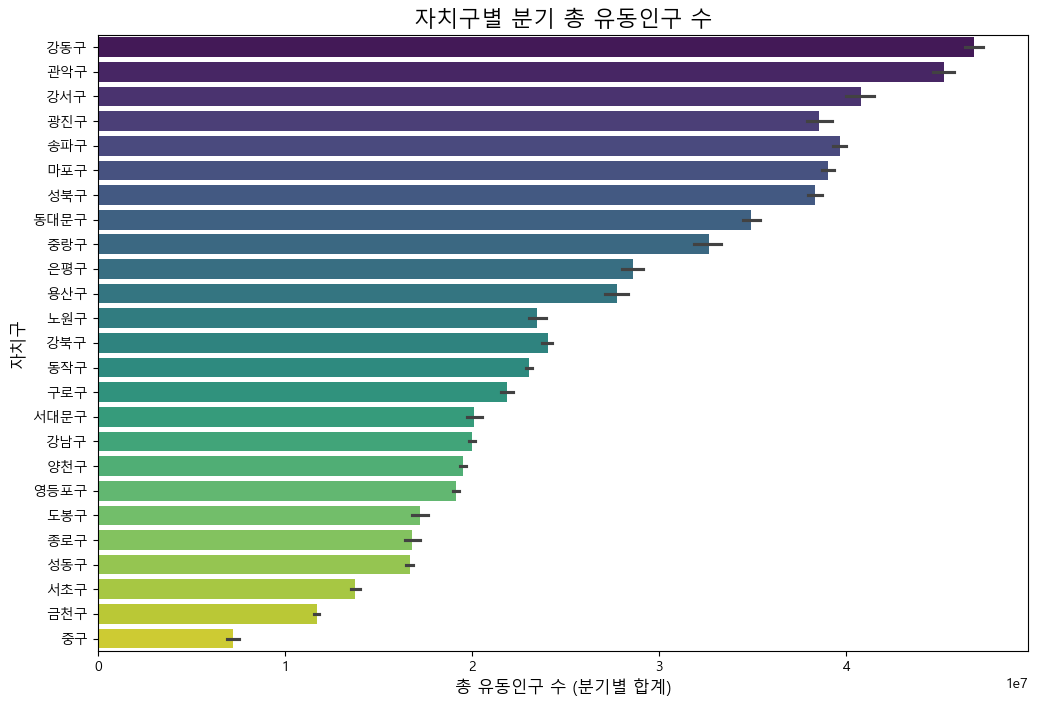

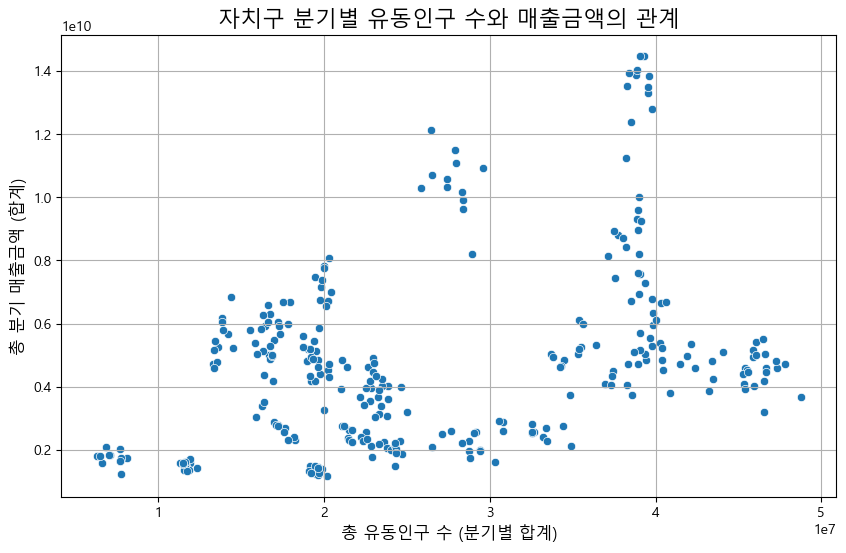

In [34]:
df_gu_sorted = df_gu_quarterly.sort_values(by='총_유동인구_수', ascending=False)

plt.figure(figsize=(12, 8))
# '총_유동인구_수'를 x축, '자치구'를 y축으로 하는 막대 그래프 생성
sns.barplot(x='총_유동인구_수', y='자치구', data=df_gu_sorted, palette='viridis')
plt.title('자치구별 분기 총 유동인구 수', fontsize=16)
plt.xlabel('총 유동인구 수 (분기별 합계)', fontsize=12)
plt.ylabel('자치구', fontsize=12)
plt.show()


# 유동인구와 분기 매출 관계 시각화 (산점도) ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='총_유동인구_수', y='분기_매출금액', data=df_gu_quarterly)
plt.title('자치구 분기별 유동인구 수와 매출금액의 관계', fontsize=16)
plt.xlabel('총 유동인구 수 (분기별 합계)', fontsize=12)
plt.ylabel('총 분기 매출금액 (합계)', fontsize=12)
plt.grid(True)
plt.show()



지역 정보를 기반으로 분석한 결과, 유동 인구수와 매출액 사이에 유의미한 관계가 있는 것으로 보인다.

In [35]:
df_to_merge = df_gu_quarterly[['자치구', '년도', '분기', '총_유동인구_수']]
df_to_merge = df_to_merge.rename(columns={'총_유동인구_수': '해당구_분기별_유동인구'})
df = pd.merge(df, df_to_merge, on=['자치구', '년도', '분기'], how='left')


# 데이터 전처리 (Data Preprocessing)

최종변수 선택 + 컬럼 정리

In [36]:
order = [
    # 1. 기본 식별자 
    '년도',
    '분기',

    # 2. 모델링 피처 (Modeling Features)
    # 2-1. 이벤트
    '코로나_집합금지_영향',
    '평균 최고기온(℃)',
    '총 강수량(mm)',

    # 2-2. 상권 특성 (범주형)
    '상권_변화_지표_명',
    '상권_생애주기',
    '상권_등급',
 

    # 2-3. 상권 규모
    '총_커피매장_수',
    '일반음식점_점포수',
    '집객시설_수',

    # 2-4. 인구 구성
    '직장인구_그룹',
    '핵심소비층_비율',
    '피크타임_비율',
    '해당구_분기별_직장인구',
    '해당구_분기별_유동인구',

    # 2-5. 구매력
    '월_평균_소득_금액',
    
    # 3. 타겟 변수 (Target Variable)
    '분기_매출금액' 
]

df = df[order]

데이터 확인

In [37]:
def wrangling(train_set):
    
    print("---Shape---")
    display(train_set.shape)
    
    print("---Info----")
    display(train_set.info())
    
    print("---NaN----")
    display(train_set.isna().sum())
    
	#중복되는지 확인
    print("---Duplicated---")
    display(train_set[train_set.duplicated()])
    
    print("---Description---")
    display(train_set.describe())
    
    print("---Unique---")
    display(train_set.nunique())
    
wrangling(df)

---Shape---


(7404, 18)

---Info----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7404 entries, 0 to 7403
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   년도            7404 non-null   int64   
 1   분기            7404 non-null   int64   
 2   코로나_집합금지_영향   7404 non-null   int64   
 3   평균 최고기온(℃)    7404 non-null   float64 
 4   총 강수량(mm)     7404 non-null   float64 
 5   상권_변화_지표_명    7404 non-null   object  
 6   상권_생애주기       7404 non-null   category
 7   상권_등급         7404 non-null   object  
 8   총_커피매장_수      7404 non-null   int64   
 9   일반음식점_점포수     7404 non-null   int64   
 10  집객시설_수        7284 non-null   float64 
 11  직장인구_그룹       7404 non-null   object  
 12  핵심소비층_비율      7404 non-null   float64 
 13  피크타임_비율       7404 non-null   float64 
 14  해당구_분기별_직장인구  7404 non-null   float64 
 15  해당구_분기별_유동인구  7404 non-null   float64 
 16  월_평균_소득_금액    7404 non-null   int64   
 17  분기_매출금액       7404 non-null   int64   
d

None

---NaN----


년도                0
분기                0
코로나_집합금지_영향       0
평균 최고기온(℃)        0
총 강수량(mm)         0
상권_변화_지표_명        0
상권_생애주기           0
상권_등급             0
총_커피매장_수          0
일반음식점_점포수         0
집객시설_수          120
직장인구_그룹           0
핵심소비층_비율          0
피크타임_비율           0
해당구_분기별_직장인구      0
해당구_분기별_유동인구      0
월_평균_소득_금액        0
분기_매출금액           0
dtype: int64

---Duplicated---


Empty DataFrame
Columns: [년도, 분기, 코로나_집합금지_영향, 평균 최고기온(℃), 총 강수량(mm), 상권_변화_지표_명, 상권_생애주기, 상권_등급, 총_커피매장_수, 일반음식점_점포수, 집객시설_수, 직장인구_그룹, 핵심소비층_비율, 피크타임_비율, 해당구_분기별_직장인구, 해당구_분기별_유동인구, 월_평균_소득_금액, 분기_매출금액]
Index: []

---Description---


년도           분기  코로나_집합금지_영향   평균 최고기온(℃)    총 강수량(mm)  \
count  7404.000000  7404.000000  7404.000000  7404.000000  7404.000000   
mean   2023.000000     2.500000     0.916667    18.770833   390.458333   
std       0.816552     1.118109     0.276404     8.863180   315.907739   
min    2022.000000     1.000000     0.000000     6.480000    59.400000   
25%    2022.000000     1.750000     1.000000    11.400000   135.650000   
50%    2023.000000     2.500000     1.000000    18.910000   248.200000   
75%    2024.000000     3.250000     1.000000    26.292500   529.575000   
max    2024.000000     4.000000     1.000000    30.940000  1018.600000   

          총_커피매장_수    일반음식점_점포수       집객시설_수     핵심소비층_비율      피크타임_비율  \
count  7404.000000  7404.000000  7284.000000  7404.000000  7404.000000   
mean     12.408563   187.225419    16.148270     0.492068     0.411771   
std      10.430534   114.784155    10.537757     0.093471     0.064316   
min       3.000000     0.000000     1.000000     0.000000     0.000000   
25%       7.000000   107.000000     8.000000     0.420299     0.368973   
50%       9.000000   168.000000    14.000000     0.474684     0.399870   
75%      15.000000   248.000000    22.000000     0.547762     0.444025   
max     124.000000   704.000000    64.000000     0.788438     0.696867   

       해당구_분기별_직장인구  해당구_분기별_유동인구    월_평균_소득_금액       분기_매출금액  
count   7404.000000  7.404000e+03  7.404000e+03  7.404000e+03  
mean   26233.116559  2.886752e+07  2.766244e+06  1.954182e+08  
std    16555.240121  1.082130e+07  5.892606e+05  2.905779e+08  
min     5068.000000  6.267855e+06  1.554706e+06  2.541300e+05  
25%    14641.000000  1.964801e+07  2.382209e+06  3.612199e+07  
50%    20240.000000  2.790678e+07  2.592441e+06  9.649800e+07  
75%    33463.000000  3.895863e+07  2.966100e+06  2.173764e+08  
max    85307.000000  4.878940e+07  5.751255e+06  3.599557e+09

---Unique---


년도                 3
분기                 4
코로나_집합금지_영향        2
평균 최고기온(℃)        12
총 강수량(mm)         12
상권_변화_지표_명         4
상권_생애주기            4
상권_등급              3
총_커피매장_수          89
일반음식점_점포수        582
집객시설_수            50
직장인구_그룹            2
핵심소비층_비율        7396
피크타임_비율         7397
해당구_분기별_직장인구     100
해당구_분기별_유동인구     300
월_평균_소득_금액       617
분기_매출금액         7229
dtype: int64

### 결측치(Missing Values) 처리

In [38]:
# 데이터 출처에서 집객시설 결측치는 해당 상권에 집객시설이 없다는는 것을 의미한다고 표기함
df['집객시설_수'].fillna(0, inplace=True)

데이터 타입에 따라 분류

In [39]:
date_col = [
    '년도',
    '분기',
]

nominal_col = [
    '년도',
    '분기',
    '코로나_집합금지_영향',
    '상권_변화_지표_명',
    '직장인구_그룹',
    '상권_생애주기',
]

ordinal_col = [
    '상권_등급'
]

numerical_col = [
    '평균 최고기온(℃)',
    '총 강수량(mm)',
    '총_커피매장_수',
    '일반음식점_점포수',
    '집객시설_수',
    '핵심소비층_비율',
    '피크타임_비율',
    '월_평균_소득_금액',
    '해당구_분기별_직장인구',
    '해당구_분기별_유동인구',]

target_col = '분기_매출금액'

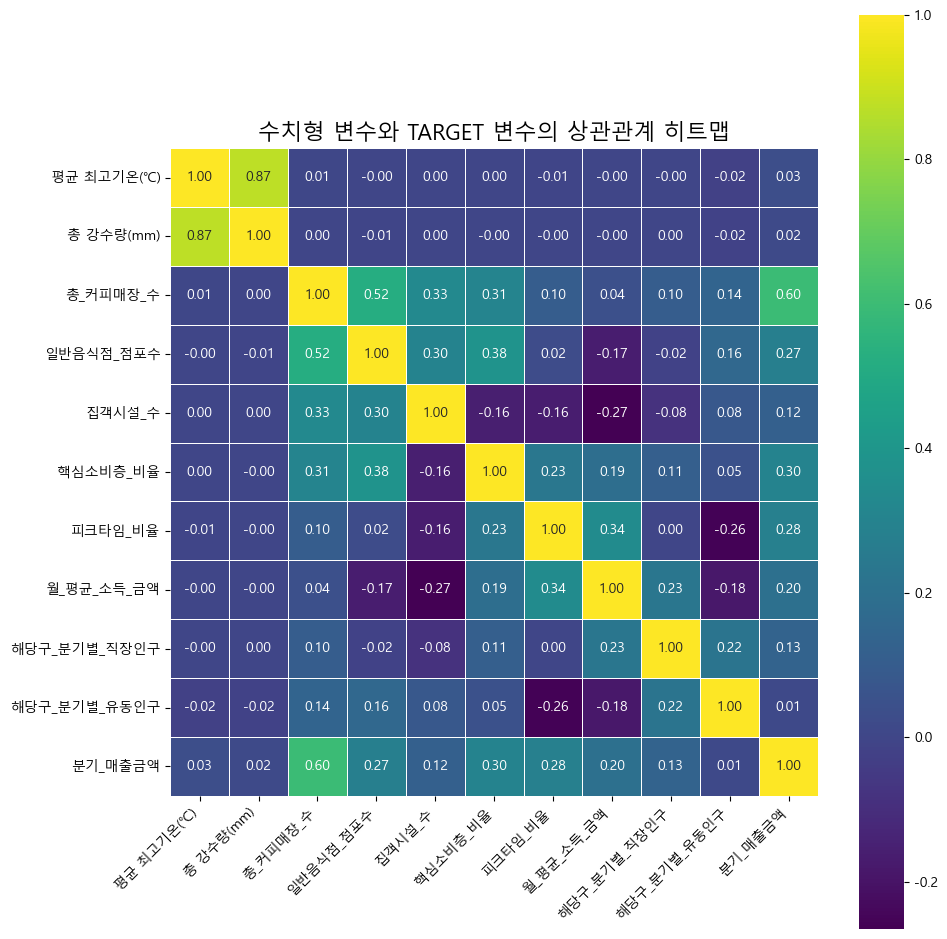

In [40]:
correlation_cols = numerical_col + [target_col]

# 1. 상관관계 행렬 계산
corr_matrix = df[correlation_cols].corr()

# 2. 상관관계 히트맵 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='viridis', 
    fmt='.2f', 
    linewidths=.5,
    square=True
)
plt.title('수치형 변수와 TARGET 변수의 상관관계 히트맵', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

데이터 분할은 시간 순서(time-series)를 기반으로 진행

훈련 데이터(train set)는 2022년, 2023년, 2024년의 각 1, 2분기 데이터를 활용  
평가 데이터(test set)는 2024년의 3, 4분기 데이터를 활용

In [41]:
test_data = df[(df['년도'] == 2024) & (df['분기'].isin([3, 4]))]
train_data = df[~((df['년도'] == 2024) & (df['분기'].isin([3, 4])))]


In [42]:
X_train = train_data.drop(target_col, axis=1)
y_train = train_data[target_col]
X_test = test_data.drop(target_col, axis=1)
y_test = test_data[target_col]

In [43]:
X_train.head(2)

년도  분기  코로나_집합금지_영향  평균 최고기온(℃)  총 강수량(mm) 상권_변화_지표_명 상권_생애주기 상권_등급  \
0  2022   1            0        6.48      112.8         정체     성숙기    상위   
1  2022   1            0        6.48      112.8         정체     성숙기    상위   

   총_커피매장_수  일반음식점_점포수  집객시설_수   직장인구_그룹  핵심소비층_비율   피크타임_비율  해당구_분기별_직장인구  \
0         4         22    18.0  4000명 미만  0.387783  0.430039       19436.0   
1         7         64    18.0  4000명 미만  0.377413  0.320637       19436.0   

   해당구_분기별_유동인구  월_평균_소득_금액  
0    16869828.0     3463885  
1    16869828.0     3474789

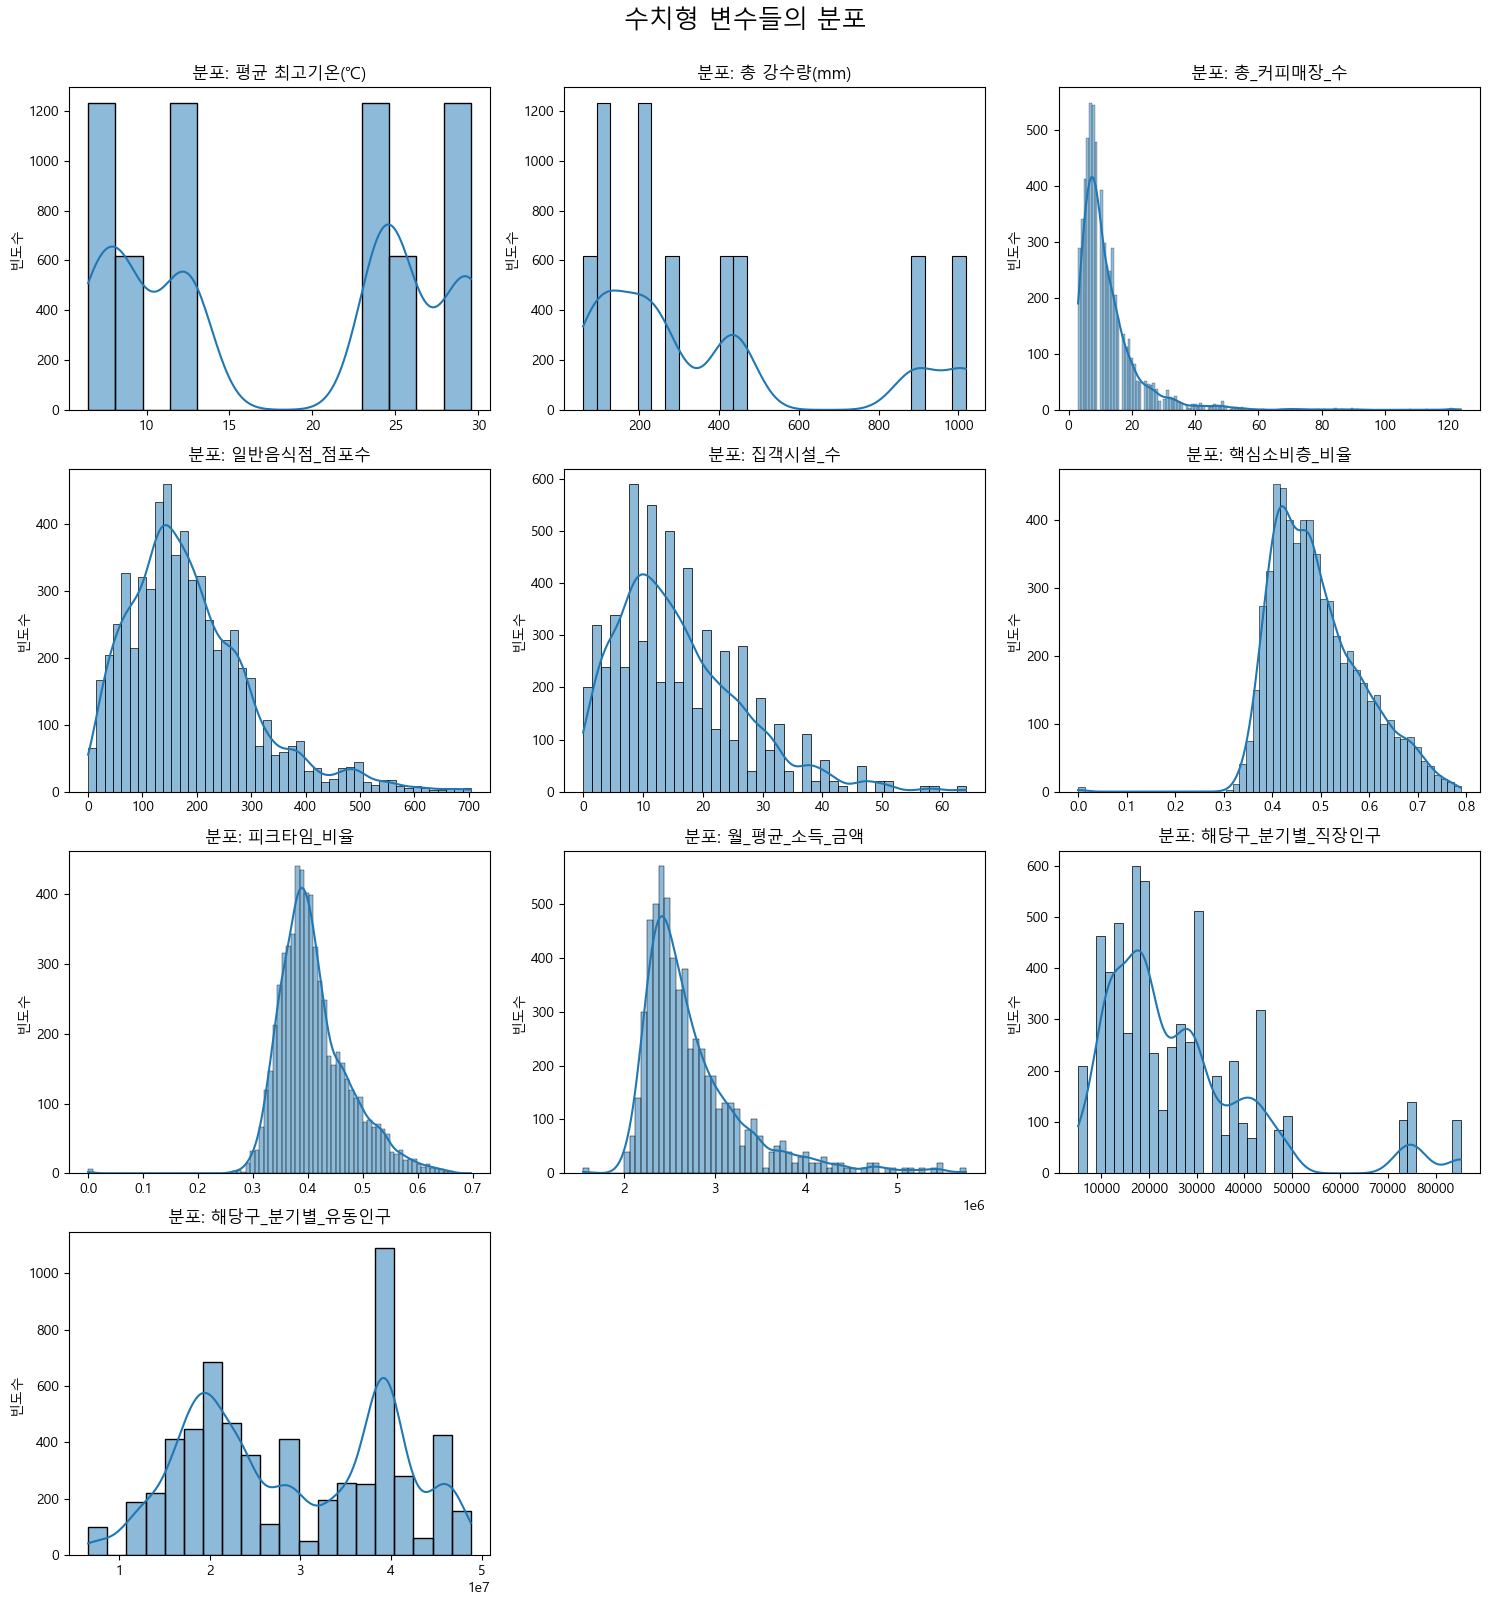

In [44]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 16)) # figsize 높이도 조절

# 2차원 배열의 axes를 1차원으로 펼쳐서 다루기 쉽게 만듭니다.
axes = axes.flatten()

# 2. 각 수치형 변수의 분포를 반복문으로 시각화 (이 부분은 그대로입니다)
for i, col in enumerate(numerical_col):
    sns.histplot(data=X_train, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'분포: {col}', fontsize=12)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('빈도수')

# 3. 남는 빈 그래프 숨기기 (총 칸 수를 12로 수정)
num_plots = len(numerical_col)
for i in range(num_plots, 12): # 9를 12로 수정
    axes[i].set_visible(False)

# 4. 전체 제목 설정 및 레이아웃 조정 (이 부분은 그대로입니다)
plt.suptitle('수치형 변수들의 분포', fontsize=18, y=1.0)
plt.tight_layout()
plt.show()

이상치 처리  
최대 혹은 최소값으로 이상치 대체

In [45]:
for col in numerical_col:

    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # X_train과 X_test를 각각 처리합니다.
    X_train[col] = np.clip(X_train[col], lower_bound, upper_bound)
    X_test[col] = np.clip(X_test[col], lower_bound, upper_bound)

로그 변환

In [46]:
cols_to_log = [
    '총_커피매장_수', '일반음식점_점포수', '집객시설_수',
    '해당구_분기별_직장인구', '해당구_분기별_유동인구'
]

for col in cols_to_log:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])

스케일링

In [47]:
scaler = StandardScaler()

# ❗ 중요: Scaler는 X_train으로만 학습(fit)시킵니다.
scaler.fit(X_train[numerical_col])

# X_train과 X_test에 각각 변환(transform)을 적용합니다.
X_train[numerical_col] = scaler.transform(X_train[numerical_col])
X_test[numerical_col] = scaler.transform(X_test[numerical_col])

순서형 변수 처리

In [48]:
grade_categories = ['하위', '중위', '상위'] 
ordinal_encoder = OrdinalEncoder(categories=[grade_categories])

ordinal_encoder.fit(X_train[ordinal_col])

# X_train과 X_test에 각각 변환(transform)을 적용
X_train[ordinal_col] = ordinal_encoder.transform(X_train[ordinal_col])
X_test[ordinal_col] = ordinal_encoder.transform(X_test[ordinal_col])


명목형 변수 처리

In [49]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

ohe.fit(X_train[nominal_col])

# 원핫인코딩 적용
X_train_ohe = ohe.transform(X_train[nominal_col])
X_test_ohe = ohe.transform(X_test[nominal_col])

ohe_cols = ohe.get_feature_names_out(nominal_col)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_cols, index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_cols, index=X_test.index)

# 기존 명목형 변수 열은 삭제
X_train = X_train.drop(columns=nominal_col)
X_test = X_test.drop(columns=nominal_col)

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)


# 모델링



--- RandomForestRegressor 모델 처리 중 ---
--- XGBRegressor 모델 처리 중 ---
--- LGBMRegressor 모델 처리 중 ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1452
[LightGBM] [Info] Number of data points in the train set: 6170, number of used features: 30
[LightGBM] [Info] Start training from score 195095392.774554
--- Ridge 모델 처리 중 ---
--- Lasso 모델 처리 중 ---


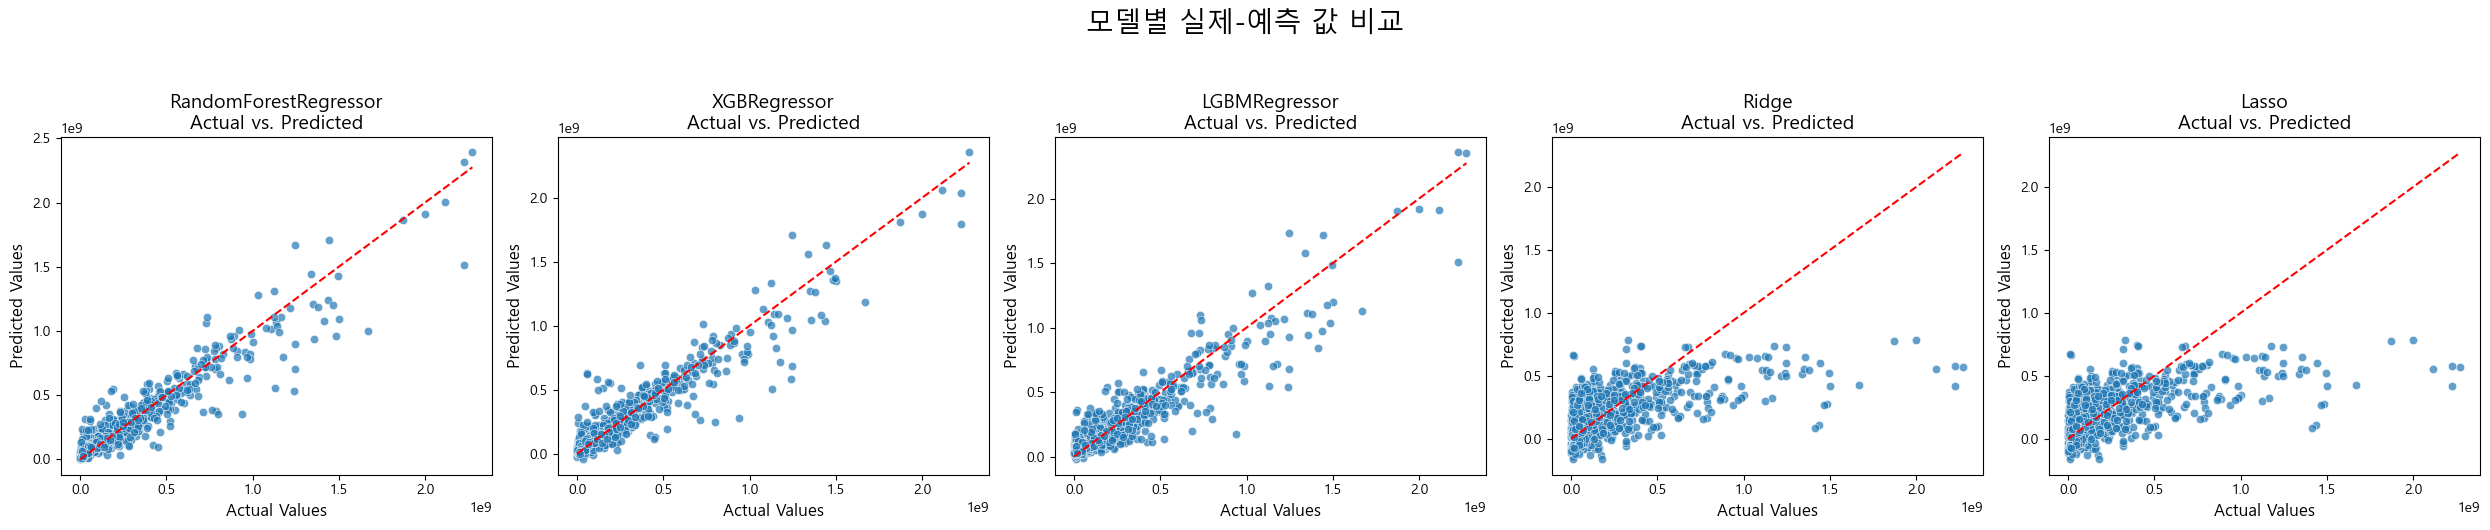

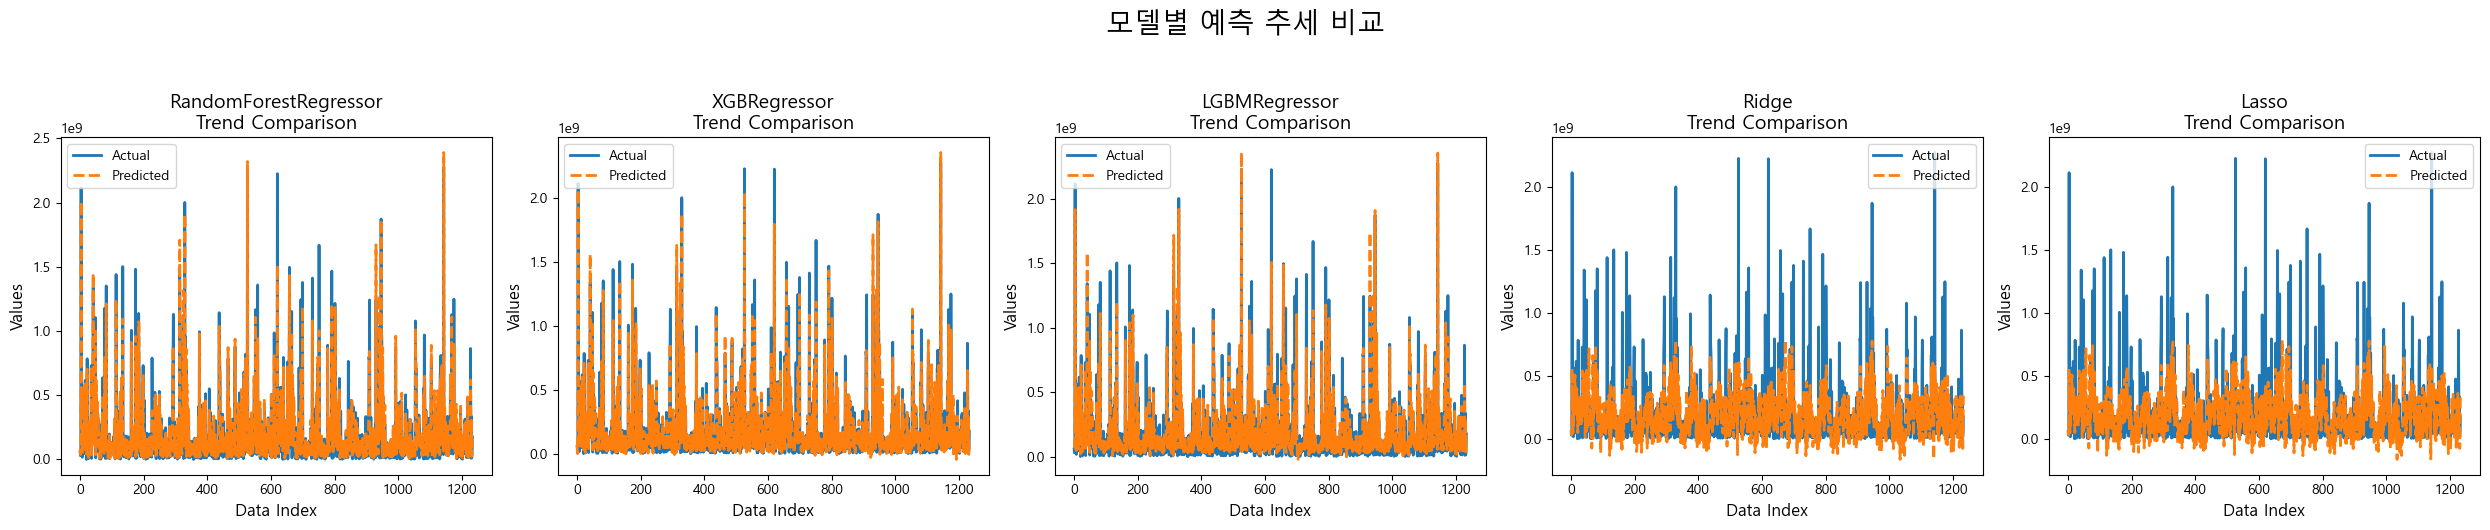

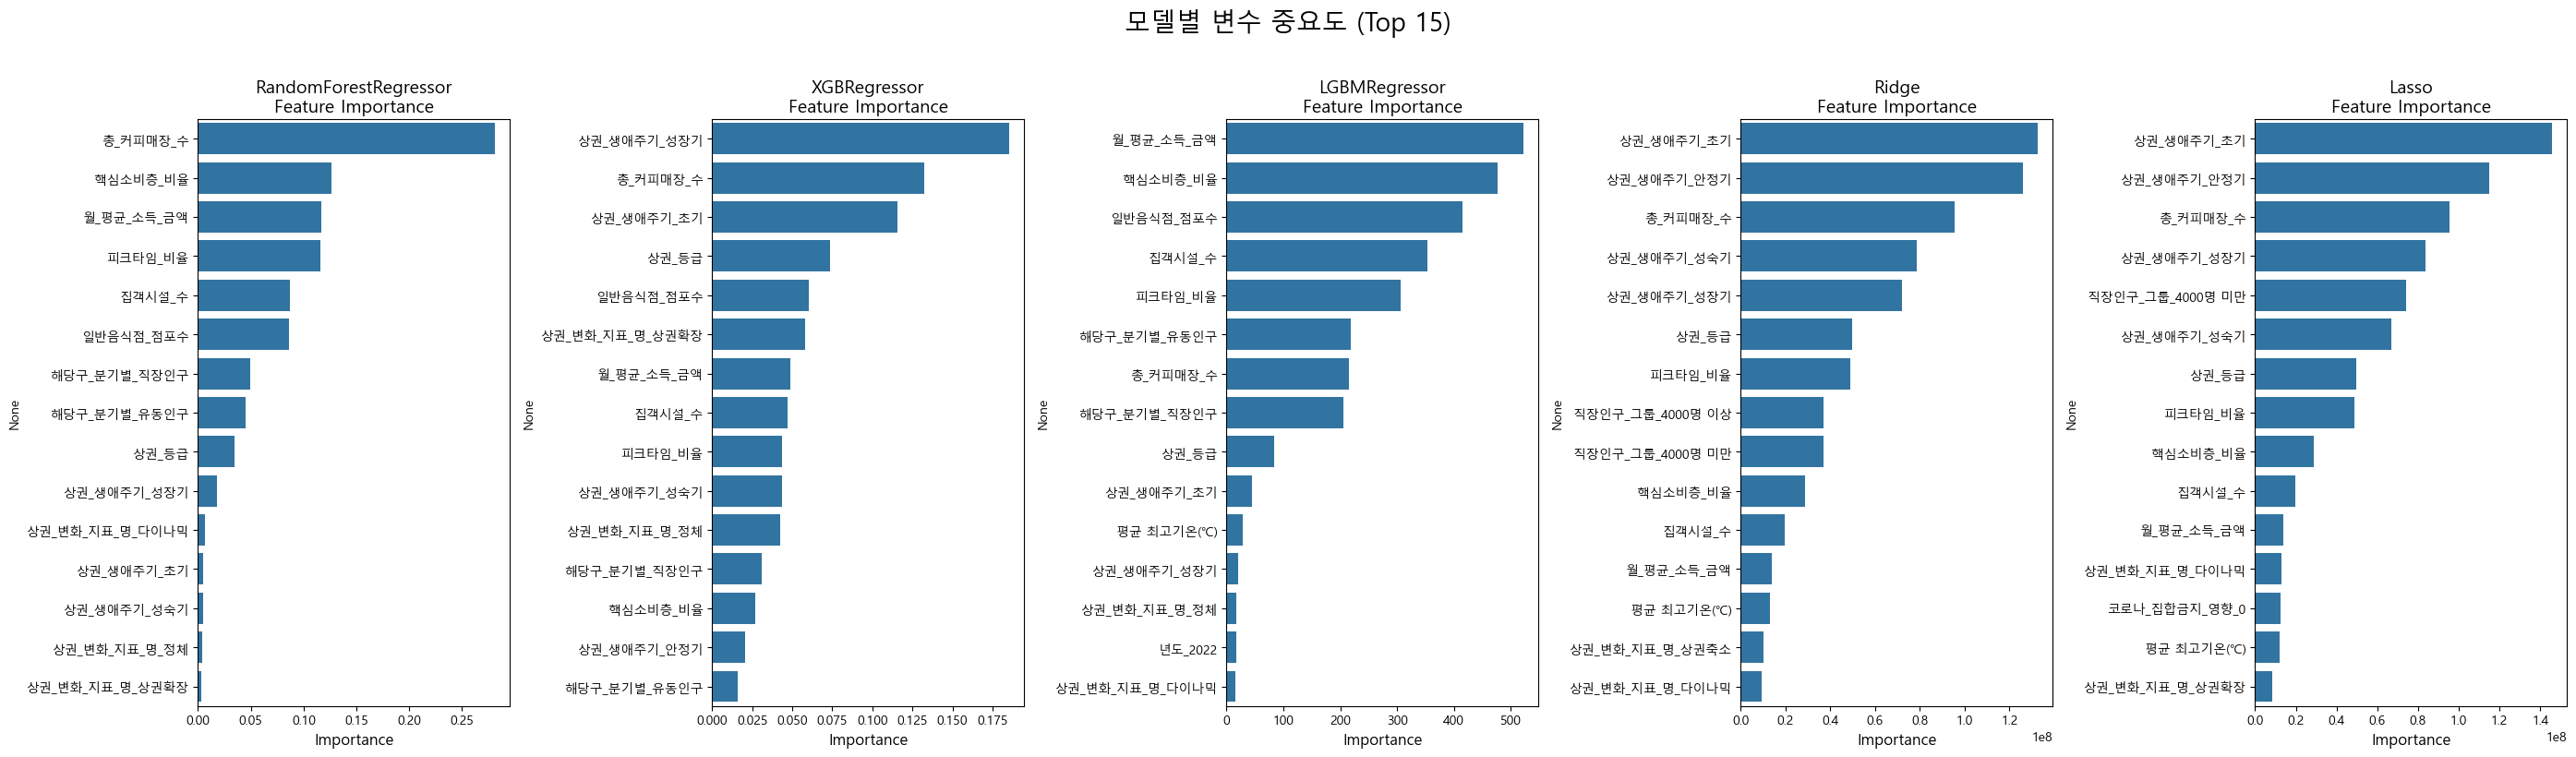



--- 최종 모델 성능 비교 ---
                   Model          RMSE        R2
0  RandomForestRegressor  8.829249e+07  0.905214
1           XGBRegressor  9.097184e+07  0.899374
2          LGBMRegressor  1.052934e+08  0.865197
3                  Ridge  2.344379e+08  0.331731
4                  Lasso  2.344499e+08  0.331662


In [50]:
models = {
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(random_state=42),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42)
}

# --------------------------------------------------------------------------
# 4. 모델 학습 및 평가
# --------------------------------------------------------------------------

predictions_dict = {}
importances_dict = {}
results_list = []

for name, model in models.items():
    print(f"--- {name} 모델 처리 중 ---")
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions_dict[name] = predictions
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    results_list.append({'Model': name, 'RMSE': rmse, 'R2': r2})
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = np.abs(model.coef_)
    importances_dict[name] = pd.Series(importances, index=X_train.columns)

# --------------------------------------------------------------------------
# 5. 시각화 (그래프 종류별로 분리)
# --------------------------------------------------------------------------

# --- 시각화 1: 실제 값 vs 예측 값 산점도 ---
fig1, axes1 = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
for i, name in enumerate(models.keys()):
    sns.scatterplot(x=y_test, y=predictions_dict[name], alpha=0.7, ax=axes1[i])
    axes1[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes1[i].set_title(f'{name}\nActual vs. Predicted', fontsize=14)
    axes1[i].set_xlabel('Actual Values', fontsize=12)
    axes1[i].set_ylabel('Predicted Values', fontsize=12)
fig1.suptitle('모델별 실제-예측 값 비교', fontsize=20, y=1.05)
plt.tight_layout()
plt.savefig('model_actual_vs_predicted.png', bbox_inches='tight')
plt.show()


# --- 시각화 2: 인덱스 기준 실제/예측 값 추세 비교 ---
fig2, axes2 = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
for i, name in enumerate(models.keys()):
    df_plot = pd.DataFrame({'Actual': y_test, 'Predicted': predictions_dict[name]}).reset_index(drop=True)
    sns.lineplot(data=df_plot, lw=2, ax=axes2[i])
    axes2[i].set_title(f'{name}\nTrend Comparison', fontsize=14)
    axes2[i].set_xlabel('Data Index', fontsize=12)
    axes2[i].set_ylabel('Values', fontsize=12)
fig2.suptitle('모델별 예측 추세 비교', fontsize=20, y=1.05)
plt.tight_layout()
plt.savefig('model_trend_comparison.png', bbox_inches='tight')
plt.show()


# --- 시각화 3: 변수 중요도 ---
fig3, axes3 = plt.subplots(nrows=1, ncols=5, figsize=(28, 8))
for i, name in enumerate(models.keys()):
    top_features = importances_dict[name].sort_values(ascending=False).head(15)
    sns.barplot(x=top_features, y=top_features.index, ax=axes3[i])
    axes3[i].set_title(f'{name}\nFeature Importance', fontsize=14)
    axes3[i].set_xlabel('Importance', fontsize=12)
fig3.suptitle('모델별 변수 중요도 (Top 15)', fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig('model_feature_importance.png', bbox_inches='tight')
plt.show()


# --------------------------------------------------------------------------
# 6. 최종 성능 비교표 출력
# --------------------------------------------------------------------------
results_df = pd.DataFrame(results_list).sort_values(by='RMSE', ascending=True)
print("\n\n--- 최종 모델 성능 비교 ---")
print(results_df)

-----------------------------------------------------------------------------------------

# 모델에 대한 해석

- 고성능 모델군: RandomForest, XGBoost, LGBMRegressor :  
    이 모델들은 다수의 결정 트리(Decision Tree)를 결합하는 앙상블(Ensemble) 기법을 사용한다. 단일의 복잡한 규칙 대신, 단순한 질문을 기반으로 하는 수많은 트리를 생성하고 그 예측 결과를 종합하여 최종 결론을 도출한다.

    이러한 방식은 변수 간의 복잡하고 비선형적인 상호작용을 효과적으로 학습할 수 있다. 실제 카페 매출은 단순한 선형 관계로 설명되지 않으므로, 복잡한 패턴 학습에 강점을 가진 트리 기반 앙상블 모델들이 높은 성능을 보인다.  



- 저성능 모델군: Ridge, Lasso :  
    이 모델들은 선형(Linear) 모델에 해당한다. 모든 변수가 매출에 독립적이고 직선적인 영향을 미친다고 가정하며, 이는 하나의 간단한 수학 공식을 찾는 것을 목표로 한다.

    본 프로젝트의 데이터는 상관관계 분석 결과, 변수 간 비선형적 관계가 다수 존재했다. 따라서 이러한 복잡한 패턴을 반영하지 못하는 선형 모델은 상대적으로 낮은 성능을 보인 것으로 분석된다.

# 결론

1. 상권 분석 종합 결론: 성공적인 카페 상권의 조건
    5개 모델의 변수 중요도를 종합 분석한 결과, 성공적인 카페 상권은 **상권 자체의 활력(Micro-level)**과 **배후지의 특성(Macro-level)**이라는 두 가지 축으로 설명된다.

        1-1. 상권 자체의 활력 (Micro-level Factors)
        모델들은 개별 상권이 가진 내부적 동력을 중요하게 판단한다.

        핵심 요인: 총_커피매장_수
        다수 모델에서 높은 중요도를 보이며, 단순한 경쟁 강도를 넘어 **커피 수요가 검증된 '목적지 상권'**임을 나타내는 핵심 지표이다. 이는 특정 목적을 가진 소비자가 해당 지역을 방문함을 시사하며, 높은 잠재 수요를 의미한다.

        성장 잠재력: 상권_생애주기 (특히 '성장기', '초기')
        XGBoost와 선형 모델은 '성장기' 또는 '초기' 단계의 상권을 중요 변수로 평가한다. 이는 성숙 단계의 고임대료 상권보다, 발전 가능성이 높은 신흥 상권의 잠재적 투자 가치가 높음을 시사한다.

        소비 시너지: 일반음식점_점포수, 집객시설_수
        다수 모델에서 중요하게 나타난 변수로, 주변 음식점은 식후 수요를, 집객시설은 안정적인 유동인구를 확보하는 시너지 효과를 창출한다.

        1-2. 배후지의 특성 (Macro-level Factors)
        개별 상권의 동력과 더불어, 상권이 속한 지역 전체의 거시적 특성 또한 매출에 주요한 영향을 미친다.

        구매력의 원천: 월_평균_소득_금액
        LGBM과 RandomForest 모델에서 최상위 중요도를 보인 변수로, 카페가 기호식품이라는 점에서 소비자의 구매력이 안정적 매출의 전제 조건임을 나타낸다.

        수요의 질: 핵심소비층_비율, 피크타임_비율
        단순 유동인구의 양보다, 주 고객층의 비율(핵심소비층_비율)과 특정 시간대의 집중도(피크타임_비율)가 더 중요하다. 이는 유동인구의 **'양'이 아닌 '질'과 '패턴'**이 실제 수요를 결정함을 보여준다.

        거시적 배경: 해당구_분기별_직장인구 및 유동인구
        파생변수인 '구' 단위의 거시적 인구 규모는, 상권이 속한 지역 자체가 업무, 쇼핑, 문화의 중심지로서 외부 방문객을 유인하는 힘을 가져야 함을 의미한다.

2. 데이터 기반 최적 입지 전략 도출
    상기 분석 결과를 바탕으로, 신규 출점 시 실패 확률을 최소화하고 성공 가능성을 극대화하는 3단계 입지 선정 전략을 다음과 같이 도출한다.

        1단계: 잠재력 있는 '숲' 탐색 (거시적 후보지 선정)

        소득 수준 필터링: 월_평균_소득_금액이 높은 자치구를 1차 후보군으로 선정한다.

        배후 수요 압축: 1차 후보군 내에서 해당구_분기별_직장인구와 핵심소비층_비율이 높은 지역을 최종 후보지로 압축한다. 이는 구매력을 갖춘 핵심 고객이 풍부한 지역을 식별하는 과정이다.

        2단계: 성장하는 '나무' 선택 (미시적 상권 분석)

        성장 단계 필터링: 최종 후보 자치구 내에서 상권_생애주기가 **'성장기' 또는 '초기'**인 상권을 식별한다. 이는 과도한 경쟁 및 고임대료 리스크를 회피하고 미래 가치를 선점하는 전략이다.

        수요 검증: 식별된 상권의 총_커피매장_수를 통해 기검증된 수요 수준과 시장 포화도를 종합적으로 판단한다.

        3단계: 최종 입지 결정 및 시너지 분석

        시너지 효과 분석: 최종 후보 상권 내에서 일반음식점_점포수와 집객시설_수가 밀집하여 시너지 효과를 극대화할 수 있는 구체적인 위치를 탐색한다.

        최종 결정: 상기 모든 조건을 충족하는 지점을 최적 입지로 결정한다. 본 전략은 데이터에 기반하여 **'구매력을 갖춘 핵심 고객이 풍부한 지역'**에서 **'성장 잠재력이 높은 상권'**을 찾아내는 과학적 의사결정 과정이다.